In [22]:
import random
from collections import Counter
from os import path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch

# from community import community_louvain
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from torch.nn import functional as F
from torch.nn.functional import cosine_similarity
from torch.optim import Adam
from torch_geometric.data import Batch, Data
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import BatchNorm, MessagePassing
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.utils import to_networkx
from torch_scatter import scatter_mean

In [23]:
def acc_f1(output, labels, average="binary", logging=None, verbose=True):
    preds = output.max(1)[1].type_as(labels)
    if preds.is_cuda:
        preds = preds
        labels = labels
    accuracy = accuracy_score(preds, labels)
    f1 = f1_score(preds, labels, average=average)
    return accuracy, f1


def dynamic_partition(data, partitions, num_partitions):
    res = []
    for i in range(num_partitions):
        res.append(data[torch.where(partitions == i)])
    return res


def adj_matrix_to_edge_index(adj_matrix, device=None):
    edge_index = [[], []]
    for i, row in enumerate(adj_matrix.detach().numpy().tolist()):
        for j, cell_value in enumerate(row[i + 1 :]):
            if cell_value == 1:
                edge_index[0].append(i)
                edge_index[1].append(j)
        edge_index[0].append(i)
        edge_index[1].append(i)
    edge_index = torch.tensor(edge_index, dtype=torch.int64)
    if device:
        edge_index = edge_index.to(device)
    return edge_index


def create_batch(sizes):
    sizes = sizes.tolist()
    sizes = list(map(int, sizes))
    batch = []
    for i, size in enumerate(sizes):
        batch.extend([i] * size)
    batch = torch.tensor(batch, dtype=torch.int64)
    return batch


def trim_feats(feats, sizes):
    stacked_num_nodes = sum(sizes)
    stacked_tree_feats = torch.zeros(
        (stacked_num_nodes, feats.shape[-1]), dtype=torch.float64
    )
    start_index = 0
    for i, size in enumerate(sizes):
        end_index = start_index + size
        stacked_tree_feats[start_index:end_index, :] = feats[i, :size, :]
        start_index = end_index
    return stacked_tree_feats


def pairwise_cosine_similarity(a, b):
    a_norm = torch.norm(a, dim=1).unsqueeze(-1)
    b_norm = torch.norm(b, dim=1).unsqueeze(-1)
    return torch.matmul(a_norm, b_norm.T)


def compute_crosss_attention(x_i, x_j):
    a = pairwise_cosine_similarity(x_i, x_j)
    a_i = F.softmax(a, dim=1)
    a_j = F.softmax(a, dim=0)
    att_i = torch.matmul(a_i, x_j)
    att_j = torch.matmul(a_j.T, x_i)
    return att_i, att_j


def batch_block_pair_attention(data, batch, n_graphs):
    results = [None for _ in range(n_graphs * 2)]
    partitions = dynamic_partition(data, batch, n_graphs * 2)
    for i in range(0, n_graphs):
        x = partitions[i]
        y = partitions[i + n_graphs]
        attention_x, attention_y = compute_crosss_attention(x, y)
        results[i] = attention_x
        results[i + n_graphs] = attention_y
    results = torch.cat(results, dim=0)
    results = results.view(data.shape)
    return results


def calculate_accuracy(emb_1, emb_2, labels, margin):
    distances = torch.norm(emb_1 - emb_2, p=2, dim=1)
    threshold = margin
    predictions = torch.where(distances < threshold, 1, -1)
    correct_predictions = torch.eq(predictions, labels).sum().item()
    total_predictions = labels.size(0)
    accuracy = correct_predictions / total_predictions
    return accuracy

In [24]:
def spectral_clustering(edge_index, num_nodes, num_clusters=10):
    adjacency_matrix = torch.zeros((num_nodes, num_nodes), dtype=torch.float)
    adjacency_matrix[edge_index[0], edge_index[1]] = 1
    adjacency_matrix_np = adjacency_matrix.numpy()
    clustering = SpectralClustering(n_clusters=num_clusters, affinity='precomputed', assign_labels='discretize').fit(adjacency_matrix_np)
    return clustering.labels_

In [25]:
def cdm(node_embeddings, epsilon=1e-6, tau=0.5):
    exp_embeddings = torch.exp(node_embeddings)
    sum_exp_embeddings = torch.sum(exp_embeddings, dim=1, keepdim=True)
    q_i_tilde = exp_embeddings / sum_exp_embeddings
    max_q_i_tilde = torch.max(q_i_tilde, dim=1, keepdim=True).values
    q_i = q_i_tilde / (max_q_i_tilde + epsilon)
    r_i = (q_i >= tau).int()    
    class_assignments = r_i.tolist()
    node_classes = [assignment.index(1) if 1 in assignment else -1 for assignment in class_assignments]
    
    return torch.tensor(node_classes)

In [26]:
class GraphMatchingConvolution(MessagePassing):
    def __init__(self, in_channels, out_channels, args, aggr="add"):
        super(GraphMatchingConvolution, self).__init__(aggr=aggr)
        self.args = args
        self.lin_node = torch.nn.Linear(in_channels, out_channels)
        self.lin_message = torch.nn.Linear(out_channels * 2, out_channels)
        self.lin_passing = torch.nn.Linear(out_channels + in_channels, out_channels)
        self.batch_norm = BatchNorm(out_channels)

    def forward(self, x, edge_index, batch):
        x_transformed = self.lin_node(x)
        return self.propagate(edge_index, x=x_transformed, original_x=x, batch=batch)

    def message(self, edge_index_i, x_i, x_j):
        x = torch.cat([x_i, x_j], dim=1)
        m = self.lin_message(x)
        return m

    def update(self, aggr_out, edge_index, x, original_x, batch):
        n_graphs = torch.unique(batch).shape[0]
        cross_graph_attention = batch_block_pair_attention(original_x, batch, n_graphs)
        attention_input = original_x - cross_graph_attention
        aggr_out = self.lin_passing(torch.cat([aggr_out, attention_input], dim=1))
        aggr_out = self.batch_norm(aggr_out)
        return aggr_out, edge_index, batch, cross_graph_attention


class GraphAggregator(torch.nn.Module):
    def __init__(self, in_channels, out_channels, args):
        super(GraphAggregator, self).__init__()
        self.lin = torch.nn.Linear(in_channels, out_channels)
        self.lin_gate = torch.nn.Linear(in_channels, out_channels)
        self.lin_final = torch.nn.Linear(out_channels, out_channels)
        self.args = args

    def forward(self, x, edge_index, batch):
        x_states = self.lin(x)
        x_gates = torch.nn.functional.softmax(self.lin_gate(x), dim=1)
        x_states = x_states * x_gates
        x_states = scatter_mean(x_states, batch, dim=0)
        x_states = self.lin_final(x_states)
        return x_states

In [27]:
class GraphMatchingNetwork(torch.nn.Module):
    def __init__(self, args):
        super(GraphMatchingNetwork, self).__init__()
        self.args = args
        self.margin = self.args.margin
        if args.n_classes > 2:
            self.f1_average = "micro"
        else:
            self.f1_average = "binary"
        self.layers = torch.nn.ModuleList()
        self.layers.append(
            GraphMatchingConvolution(self.args.feat_dim, self.args.dim, args)
        )
        for _ in range(self.args.num_layers - 1):
            self.layers.append(
                GraphMatchingConvolution(self.args.dim, self.args.dim, args)
            )
        self.aggregator = GraphAggregator(self.args.dim, self.args.dim, self.args)
        self.clusters = []
        self.kmeans = KMeans(n_clusters=8, n_init=8)
        self.agglomerative = AgglomerativeClustering(n_clusters=7)
        self.layer_outputs = []
        self.layer_cross_attentions = []

    def compute_emb(self, feats, edge_index, batch, sizes_1, sizes_2):
        for i in range(self.args.num_layers):
            feats, edge_index, batch, cross_graph_attention = self.layers[i](feats, edge_index, batch)
            x_first_graph = feats[:sizes_1.item()]
            x_second_graph = feats[sizes_1.item():sizes_1.item()+sizes_2.item()]
            self.layer_outputs.append((x_first_graph, x_second_graph))
            self.layer_cross_attentions.append(cross_graph_attention)
                # cluster1 = cdm(x_first_graph)
                # cluster2 = cdm(x_second_graph)
                # cluster1 = torch.tensor(self.kmeans.fit_predict(x_first_graph.detach().numpy()))
                # cluster2 = torch.tensor(self.kmeans.fit_predict(x_second_graph.detach().numpy()))
                # cluster1 = torch.tensor(self.agglomerative.fit_predict(x_first_graph.detach().numpy()))
                # cluster2 = torch.tensor(self.agglomerative.fit_predict(x_second_graph.detach().numpy()))
                # self.clusters.append((cluster1, cluster2))

        feats = self.aggregator(feats, edge_index, batch)
        return feats, edge_index, batch

    def combine_pair_embedding(
        self, feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
    ):
        feats = torch.cat([feats_1, feats_2], dim=0)
        max_node_idx_1 = sizes_1.sum()
        edge_index_2_offset = edge_index_2 + max_node_idx_1
        edge_index = torch.cat([edge_index_1, edge_index_2_offset], dim=1)
        batch = create_batch(torch.cat([sizes_1, sizes_2], dim=0))
        feats, edge_index, batch = (
            feats.to(self.args.device),
            edge_index.to(self.args.device),
            batch.to(self.args.device),
        )
        return feats, edge_index, batch

    def forward(self, feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2):
        self.clusters = []
        self.layer_outputs = []
        self.layer_cross_attentions = []
        feats, edge_index, batch = self.combine_pair_embedding(
            feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
        )
        emb, _, _ = self.compute_emb(feats, edge_index, batch, sizes_1, sizes_2)
        emb_1 = emb[: emb.shape[0] // 2, :]
        emb_2 = emb[emb.shape[0] // 2 :, :]
        return emb_1, emb_2

    def compute_metrics(self, emb_1, emb_2, labels):
        distances = torch.norm(emb_1 - emb_2, p=2, dim=1)
        loss = F.relu(self.margin - labels * (1 - distances)).mean()
        predicted_similar = torch.where(distances < self.args.margin, torch.ones_like(labels), -torch.ones_like(labels))    
        acc = (predicted_similar == labels).float().mean()
        metrics = {"loss": loss, "acc": acc}
        return metrics

    def init_metric_dict(self):
        return {"acc": -1, "f1": -1}

    def has_improved(self, m1, m2):
        return m1["acc"] < m2["acc"]       

In [28]:
def analyze_dataset(dataset):
    num_graphs = len(dataset)
    num_classes = dataset.num_classes if hasattr(dataset, 'num_classes') else None
    num_node_features = dataset.num_node_features if hasattr(dataset, 'num_node_features') else None
    labels = [data.y.item() for data in dataset]
    num_nodes = [data.num_nodes for data in dataset]
    class_distribution = Counter(labels)
    avg_num_nodes = sum(num_nodes) / len(num_nodes)
    min_nodes = min(num_nodes)
    max_nodes = max(num_nodes)
    
    small_threshold = 30
    large_threshold = 60

    small_graphs = []
    medium_graphs = []
    large_graphs = []

    classes = {
        "class_0": [],
        "class_1": [],
        "class_2": [],
        "class_3": [],
        "class_4": [],
        "class_5": [],
    }
    
    for i in dataset:
        c = i.y
        class_name = "class_" + str(c.item())
        classes[class_name].append(i)
    
    print(f'Total number of graphs: {num_graphs}')
    if num_classes:
        print(f'Number of classes: {num_classes}')
    if num_node_features:
        print(f'Number of node features: {num_node_features}')
    print(f'Average number of nodes per graph: {int(avg_num_nodes)}')
    print(f'Max number of nodes in a graph: {max_nodes}')
    print(f'Min number of nodes in a graph: {min_nodes}')

    print('Class distribution:')
    for cls, count in class_distribution.items():
        print(f' - Class {cls}: {count} graphs ({100 * count / num_graphs:.2f}%)')
        
    plt.figure(figsize=(10, 6))
    plt.hist(num_nodes, bins=30, color='skyblue', edgecolor='black')
    plt.title('Distribution of Number of Nodes in ENZYMES Dataset')
    plt.xlabel('Number of Nodes')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    
    for graph in dataset:
        if graph.num_nodes < small_threshold:
            small_graphs.append(graph)
        elif graph.num_nodes > large_threshold:
            large_graphs.append(graph)
        else:
            medium_graphs.append(graph)

    print(f"Small graphs: {len(small_graphs)}")
    print(f"Medium graphs: {len(medium_graphs)}")
    print(f"Large graphs: {len(large_graphs)}")
    
    return small_graphs, medium_graphs, large_graphs, classes

Total number of graphs: 188
Number of classes: 2
Number of node features: 7
Average number of nodes per graph: 17
Max number of nodes in a graph: 28
Min number of nodes in a graph: 10
Class distribution:
 - Class 1: 125 graphs (66.49%)
 - Class 0: 63 graphs (33.51%)


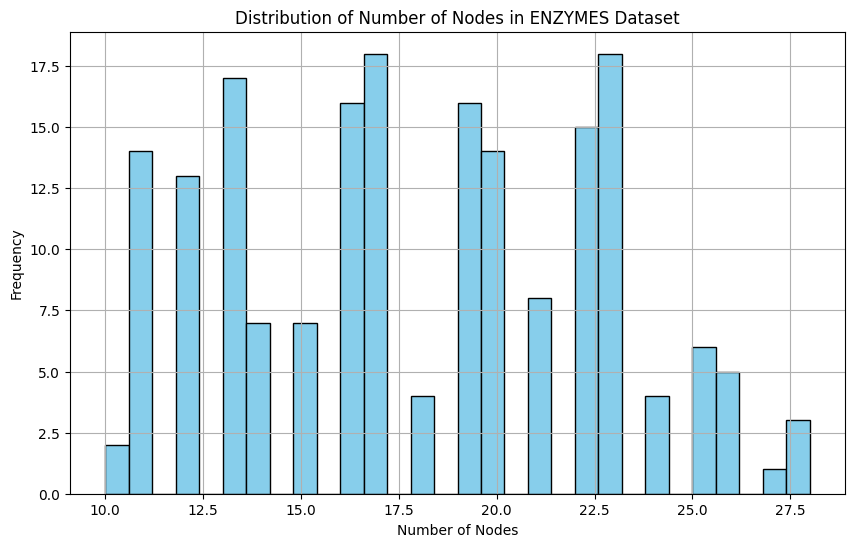

Small graphs: 188
Medium graphs: 0
Large graphs: 0


In [29]:
dataset = TUDataset(
    root="data", name="MUTAG", use_node_attr=True, transform=NormalizeFeatures()
)

small_graphs, medium_graphs, large_graphs, classes = analyze_dataset(dataset)

In [30]:
class Args:
    def __init__(self):
        self.dim = 16
        self.feat_dim = dataset.num_features
        self.num_layers = 8
        self.margin = 0.8
        self.lr = 0.001
        self.n_classes = dataset.num_classes
        self.batch_size = 1
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

args = Args()

In [31]:
def pyg_cluster(data, cluster, features):
    pca = PCA(n_components=7)
    num_nodes = data.num_nodes
    num_clusters = cluster.max().item() + 1

    reduced_features = torch.tensor(pca.fit_transform(features.detach().numpy()))
    cluster_features = scatter_mean(reduced_features, cluster, dim=0, dim_size=num_clusters)

    cluster_adj_list = {i: set() for i in range(num_clusters)}

    for edge_index in data.edge_index.t():
        source, target = edge_index
        source_cluster = cluster[source].item()
        target_cluster = cluster[target].item()
        if source_cluster != target_cluster:
            cluster_adj_list[source_cluster].add(target_cluster)
            cluster_adj_list[target_cluster].add(source_cluster)

    edge_sources = []
    edge_targets = []
    for source_cluster, target_clusters in cluster_adj_list.items():
        for target_cluster in target_clusters:
            edge_sources.append(source_cluster)
            edge_targets.append(target_cluster)

    cluster_edge_index = torch.tensor([edge_sources, edge_targets], dtype=torch.long)

    return Data(edge_index=cluster_edge_index, x=reduced_features)


# def pyg_cluster(data, cluster_assignment):
#     pca = PCA(n_components=7)
#     num_clusters = len(torch.unique(cluster_assignment))
#     num_features = data.x.size(1)
    
#     reduced_features = torch.tensor(pca.fit_transform(data.x.detach().numpy()))

#     cluster_features = torch.zeros((num_clusters, num_features))
    
#     for cluster_id in range(num_clusters):
#         nodes_in_cluster = (cluster_assignment == cluster_id).nonzero(as_tuple=True)[0]
#         cluster_features[cluster_id] = reduced_features[nodes_in_cluster].mean(dim=0)

#     edge_list = data.edge_index.t()
#     new_edges = []
#     for source, target in edge_list:
#         source_cluster = cluster_assignment[source]
#         target_cluster = cluster_assignment[target]
#         if source_cluster != target_cluster:
#             new_edges.append([source_cluster, target_cluster])

#     new_edges = torch.tensor(list(set(map(tuple, new_edges))))

#     return Data(x=cluster_features, edge_index=new_edges.t().contiguous())

In [32]:
def create_graph_pairs(dataset, num_pairs=60000):
    pairs = []
    labels = []
    for _ in range(num_pairs):
        idx1, idx2 = random.sample(range(len(dataset)), 2)
        graph1, graph2 = dataset[idx1], dataset[idx2]

        label = 1 if graph1.y == graph2.y else -1
        pairs.append((graph1, graph2))
        labels.append(label)
    return pairs, labels


def collate_graph_pairs(batch):
    graph1_list, graph2_list, labels = [], [], []
    for (graph1, graph2), label in batch:
        graph1_list.append(graph1)
        graph2_list.append(graph2)
        labels.append(label)

    batched_graph1 = Batch.from_data_list(graph1_list)
    batched_graph2 = Batch.from_data_list(graph2_list)
    labels = torch.tensor(labels)
    return batched_graph1, batched_graph2, labels


pairs, labels = create_graph_pairs(dataset)
pair_dataset = [(pair, label) for pair, label in zip(pairs, labels)]
train_loader = DataLoader(
    pair_dataset, batch_size=args.batch_size, shuffle=True, collate_fn=collate_graph_pairs
)


def train(model, train_loader, optimizer, device):
    model.train()
    train_losses = []
    train_accuracies = []
    epochs = 0

    for graph_pair, label in train_loader:
        optimizer.zero_grad()

        graph1, graph2, label = (
            graph_pair[0].to(device),
            graph_pair[1].to(device),
            label.to(device),
        )

        feats_1, edge_index_1 = graph1.x, graph1.edge_index
        feats_2, edge_index_2 = graph2.x, graph2.edge_index
        sizes_1 = torch.bincount(graph1.batch)
        sizes_2 = torch.bincount(graph2.batch)

        emb_1, emb_2 = model(feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2)
        
        # o1, o2 = model.layer_outputs[-1]
        # cdm1 = cdm(o1)
        # cdm2 = cdm(o2)
        
        # cluster1 = pyg_cluster(graph1, cdm1, o1)
        # cluster2 = pyg_cluster(graph2, cdm2, o2)
        
        # clustered_feats_1, clustered_edge_index_1 = cluster1.x, cluster1.edge_index
        # clustered_feats_2, clustered_edge_index_2 = cluster2.x, cluster2.edge_index
        # clustered_sizes_1 = torch.tensor([len(cluster1.x)])
        # clustered_sizes_2 = torch.tensor([len(cluster2.x)])
        
        # print(graph1)
        # print(graph2)
        # print(cluster1)
        # print(cluster2)
        
        # clustered_emb_1, clustered_emb_2 = model(clustered_feats_1, clustered_edge_index_1, clustered_feats_2, clustered_edge_index_2, clustered_sizes_1, clustered_sizes_2)
        
        # clustered_sim = cosine_similarity(clustered_emb_1, clustered_emb_2)[0]
        
        metrics = model.compute_metrics(emb_1, emb_2, label)
        loss = metrics["loss"]
        acc = metrics["acc"]
        
        # loss += (1 - clustered_sim)/2

        loss.backward()
        optimizer.step()

        train_losses.append(loss.detach().numpy())
        train_accuracies.append(acc.detach().numpy())

        epochs += 1
        
        if (epochs>10000 and acc>0.9):
            break

        if epochs % 50 == 0:
            print(f"Epoch: {epochs} - Loss: {loss.item():.4f}, Acc: {acc:.4f}")

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

model = GraphMatchingNetwork(args).to(args.device)
optimizer = Adam(model.parameters(), lr=args.lr)

filename = f"checkpoint_mutag_{str(args.dim)}.pth"

if path.exists(filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(args.device)
    model.to(args.device)
else:
    train(model, train_loader, optimizer, args.device)
    torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, filename)

In [33]:
def plot_graphs(edge_index, layer_clusters, graph1, graph2, sim, title=""):
    num_rows = len(layer_clusters)
    fig, axes = plt.subplots(num_rows, 4, figsize=(32, num_rows * 8))
    
    if num_rows > 1:
        x_pos = axes[0][1].get_position().x1 + (axes[0][2].get_position().x0 - axes[0][1].get_position().x1) / 2
        fig.patches.extend([plt.Rectangle((x_pos, 0), 0.001, 0.95, transform=fig.transFigure, color='black')])
        fig.text(0.25, 0.95, f'Graph1 ({graph1})', ha='center', va='center', fontsize=17)
        fig.text(0.75, 0.95, f'Graph2 ({graph2})', ha='center', va='center', fontsize=17)
        fig.text(0.5, 0.97, f"Sim: {sim:.4f}", ha='center', va='center', fontsize=17)
    else:
        x_pos = axes[1].get_position().x1 + (axes[2].get_position().x0 - axes[1].get_position().x1) / 2
        fig.patches.extend([plt.Rectangle((x_pos, 0), 0.001, 0.9, transform=fig.transFigure, color='black')])
        fig.text(0.25, 0.9, f'Graph1 ({graph1})', ha='center', va='center', fontsize=17)
        fig.text(0.75, 0.9, f'Graph2 ({graph2})', ha='center', va='center', fontsize=17)
        fig.text(0.5, 0.95, f"Sim: {sim:.4f}", ha='center', va='center', fontsize=17)
    

    fig.suptitle(title, fontsize=20, va='bottom', ha='center')
    
    axes = axes.flatten()
        
    def draw_graph(ax, G, title, node_colors):
        pos = nx.spring_layout(G) 
        if node_colors:
            nx.draw(G, pos, ax=ax, with_labels=True, node_color=node_colors, cmap=plt.get_cmap('viridis'))
        else:
            nx.draw(G, pos, ax=ax, with_labels=True)
        ax.set_title(title)

    for i, clusters in enumerate(layer_clusters):
        ax_index = 4 * i
        G_clustered = nx.Graph()
        for source, target in edge_index[0].T:
            G_clustered.add_edge(int(source), int(target))
        node_colors = [clusters[0][node] for node in G_clustered.nodes()]
        axes[ax_index].set_axis_off()
        draw_graph(axes[ax_index], G_clustered, f"Layer {i+1}", node_colors=node_colors)
        ax_index = 4 * i + 1
        G = nx.Graph()
        G.add_edges_from(edge_index[0].t().tolist())
        supernode_mapping = {node: int(cls) for node, cls in enumerate(clusters[0])}
        supergraph = nx.Graph()
        for cls in torch.unique(clusters[0]):
            supergraph.add_node(cls.item())
        for (n1, n2) in G.edges():
            sn1, sn2 = supernode_mapping[n1], supernode_mapping[n2]
            if sn1 != sn2:
                supergraph.add_edge(sn1, sn2)
        axes[ax_index].set_axis_off()
        print(supergraph)
        draw_graph(axes[ax_index], supergraph, f"Layer {i+1} Clustered", None)
        
        ax_index = 4 * i + 2
        G_clustered = nx.Graph()
        for source, target in edge_index[1].T:
            G_clustered.add_edge(int(source), int(target))
        node_colors = [clusters[1][node] for node in G_clustered.nodes()]
        axes[ax_index].set_axis_off()
        draw_graph(axes[ax_index], G_clustered, f"Layer {i+1}", node_colors=node_colors)
        ax_index = 4 * i + 3
        G = nx.Graph()
        G.add_edges_from(edge_index[1].t().tolist())
        supernode_mapping = {node: int(cls) for node, cls in enumerate(clusters[1])}
        supergraph = nx.Graph()
        for cls in torch.unique(clusters[1]):
            supergraph.add_node(cls.item())
        for (n1, n2) in G.edges():
            sn1, sn2 = supernode_mapping[n1], supernode_mapping[n2]
            if sn1 != sn2:
                supergraph.add_edge(sn1, sn2)
        axes[ax_index].set_axis_off()
        draw_graph(axes[ax_index], supergraph, f"Layer {i+1} Clustered", None)

    plt.tight_layout()
    if num_rows > 1:
        fig.subplots_adjust(top=0.9)
    else:
        fig.subplots_adjust(top=0.8)
    plt.show()
    
def create_clustered_graph(cluster, edge_index):
    G = nx.Graph()
    G.add_edges_from(edge_index.t().tolist())
    supernode_mapping = {node: int(cls) for node, cls in enumerate(cluster)}
    supergraph = nx.Graph()
    for cls in torch.unique(cluster):
        supergraph.add_node(cls.item())
    for (n1, n2) in G.edges():
        sn1, sn2 = supernode_mapping[n1], supernode_mapping[n2]
        if sn1 != sn2:
            supergraph.add_edge(sn1, sn2)
    return supergraph

0.9845359921455383










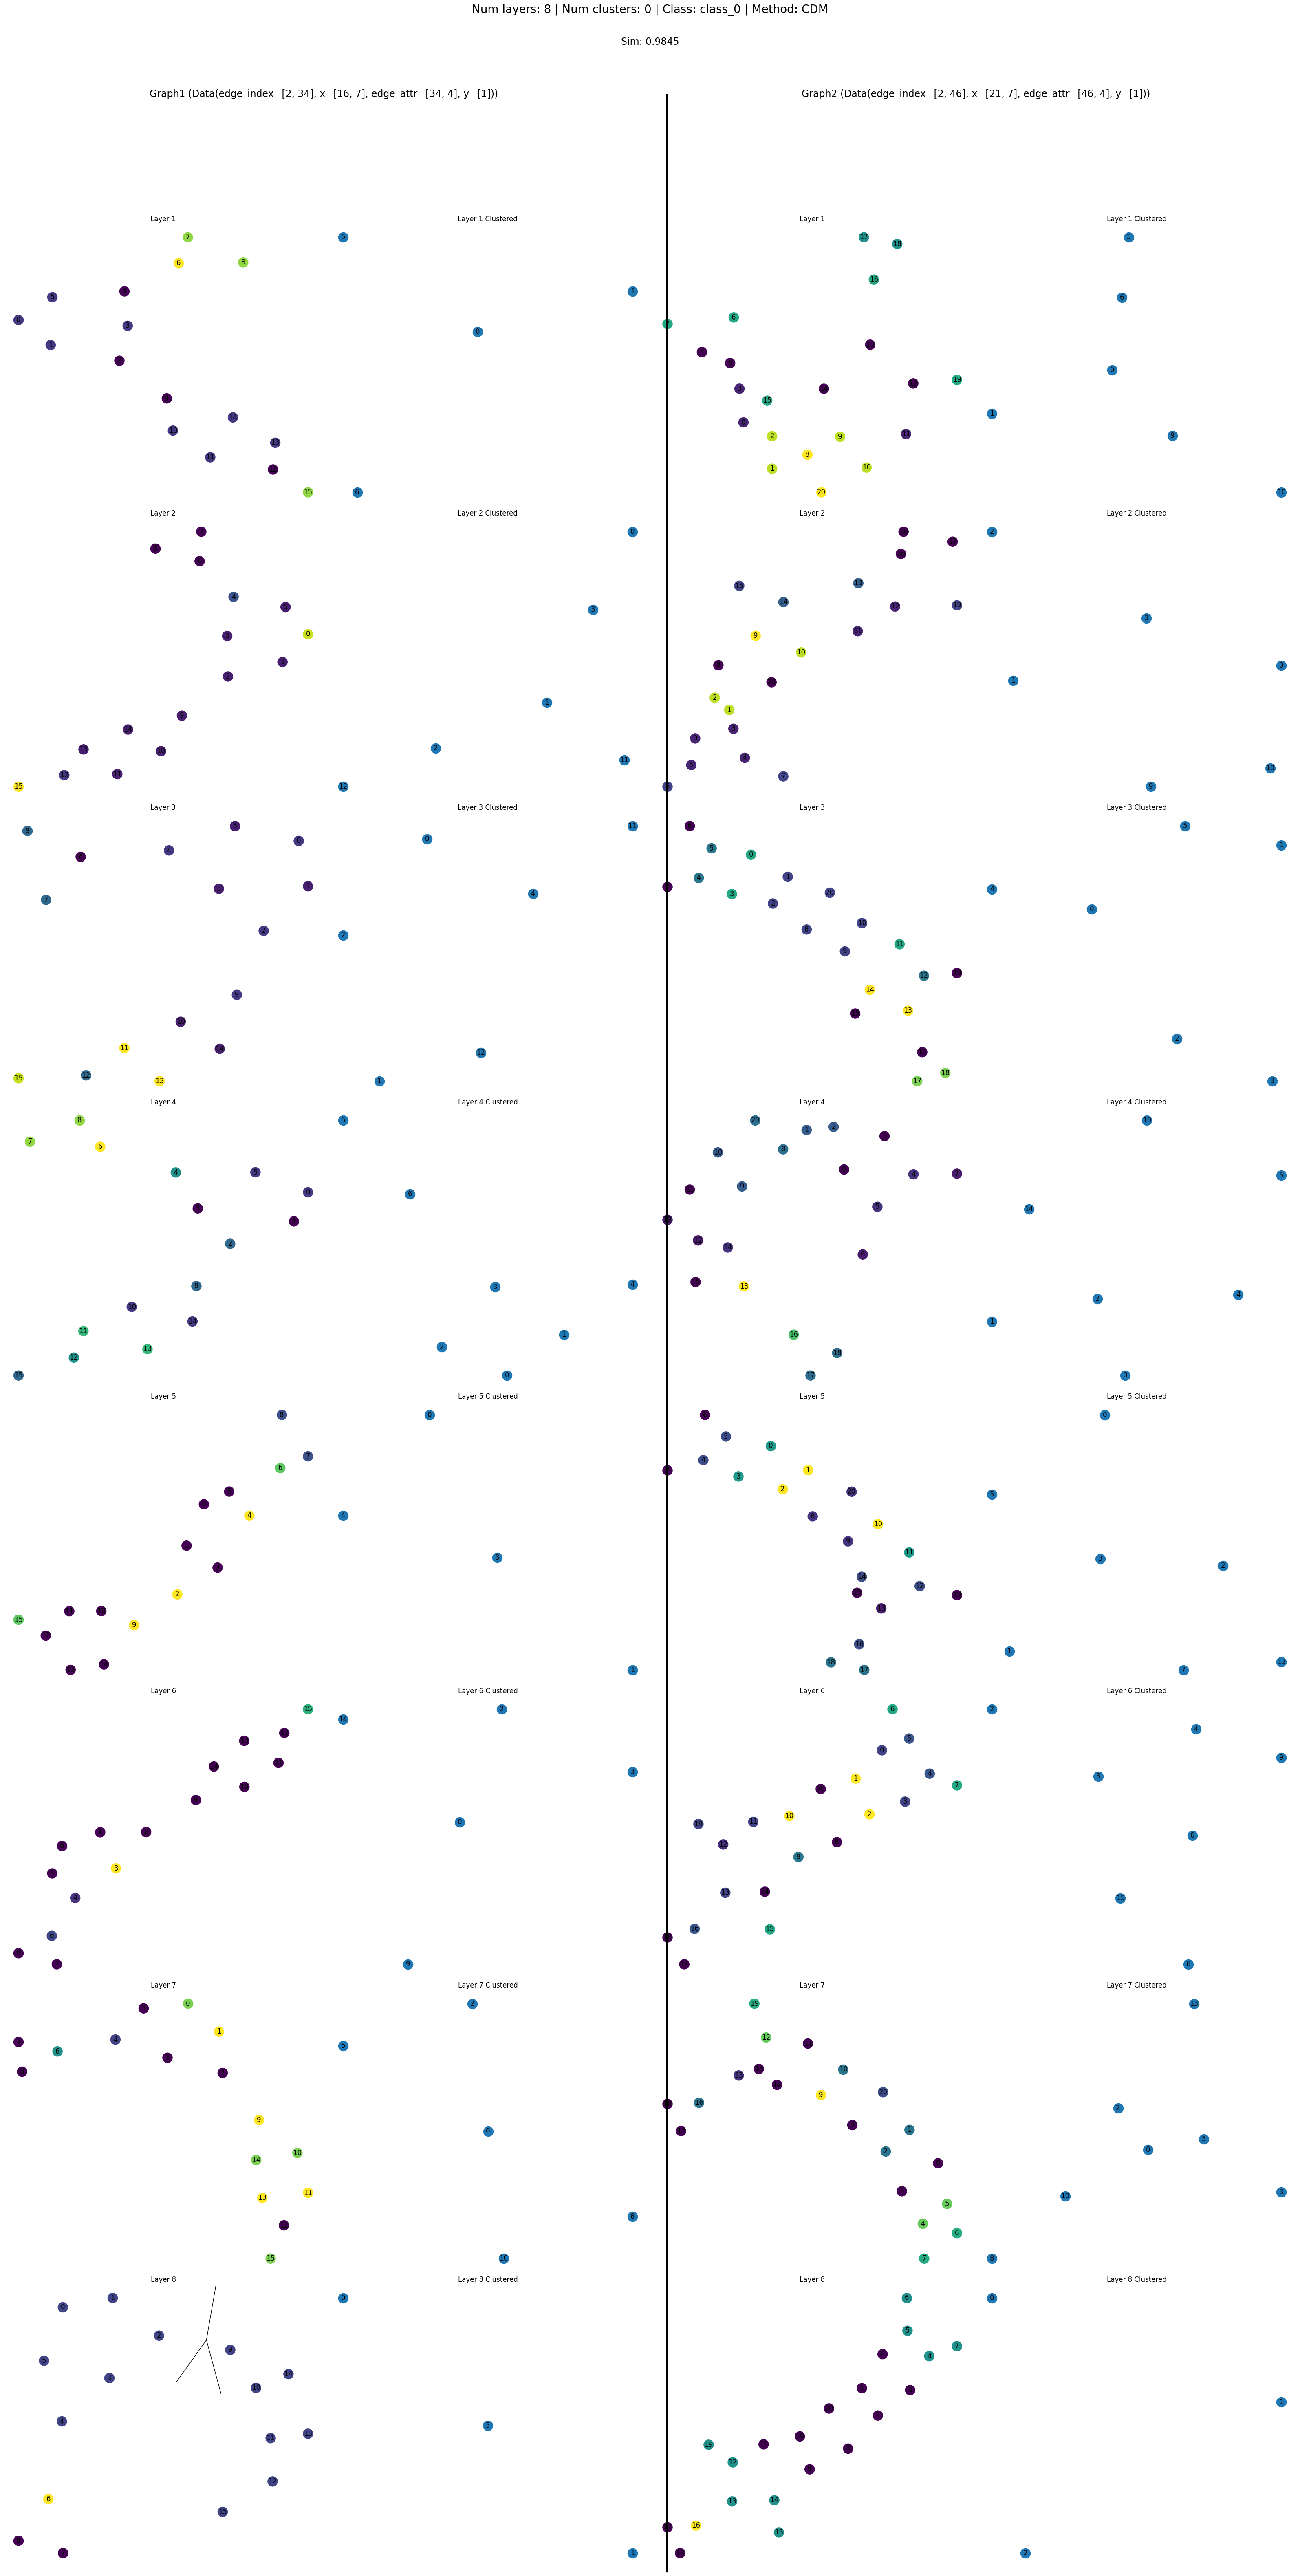

0.9923498630523682










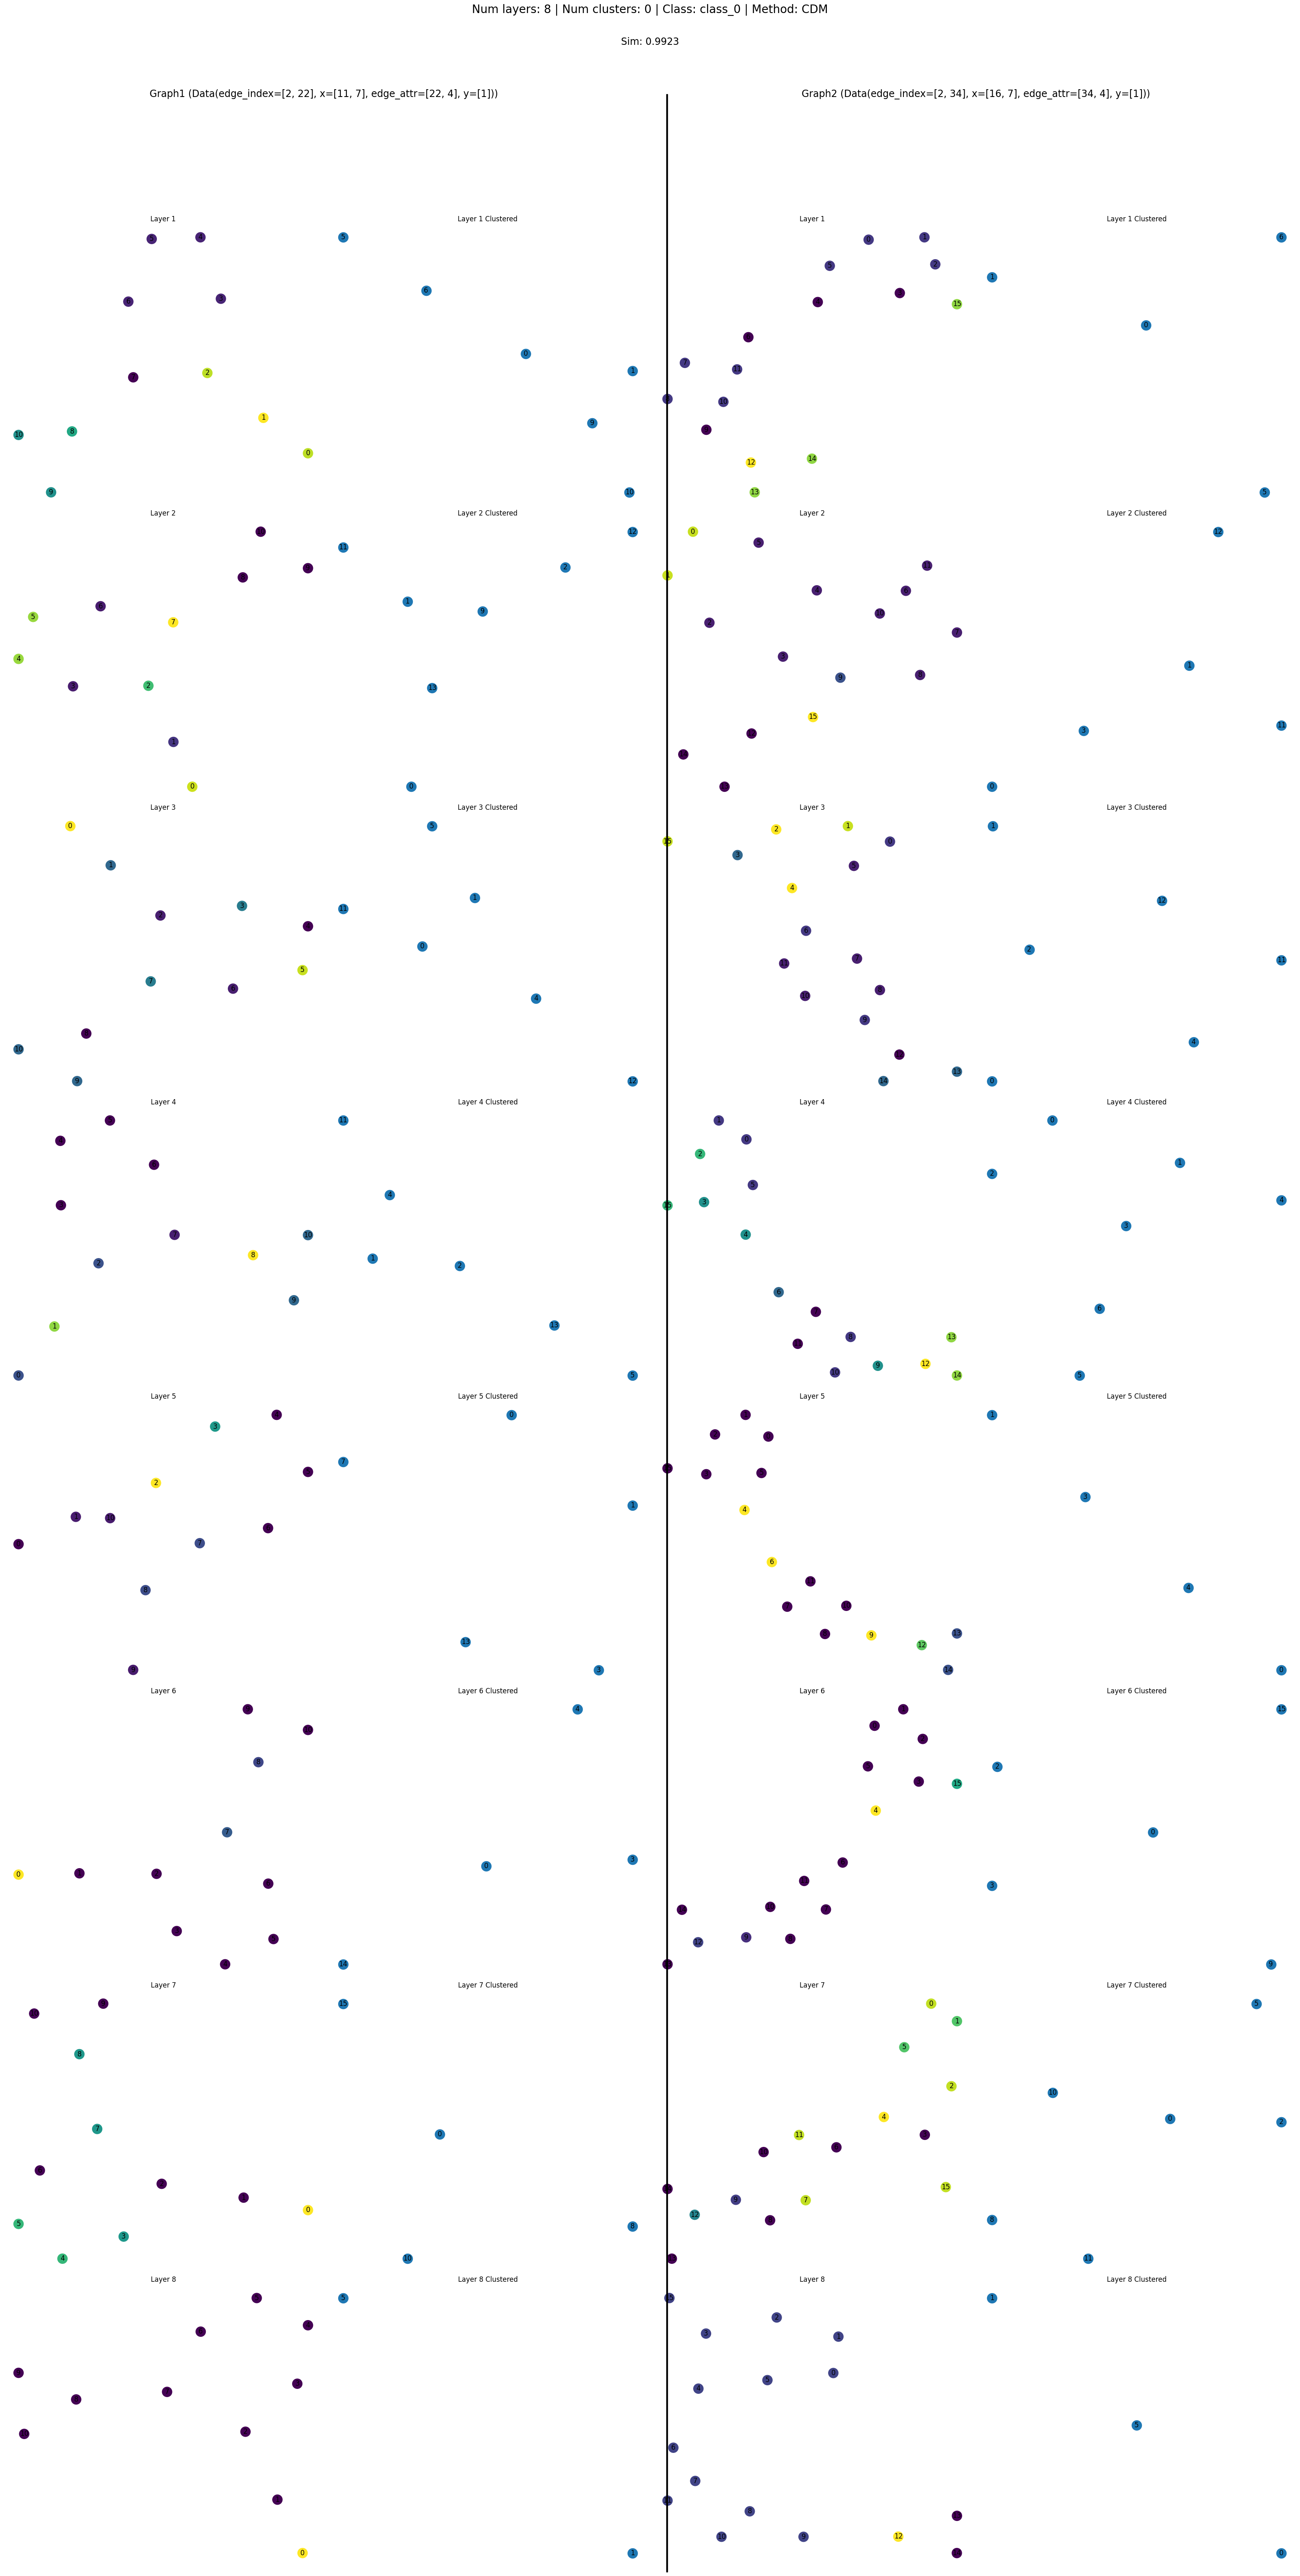

0.9948524832725525










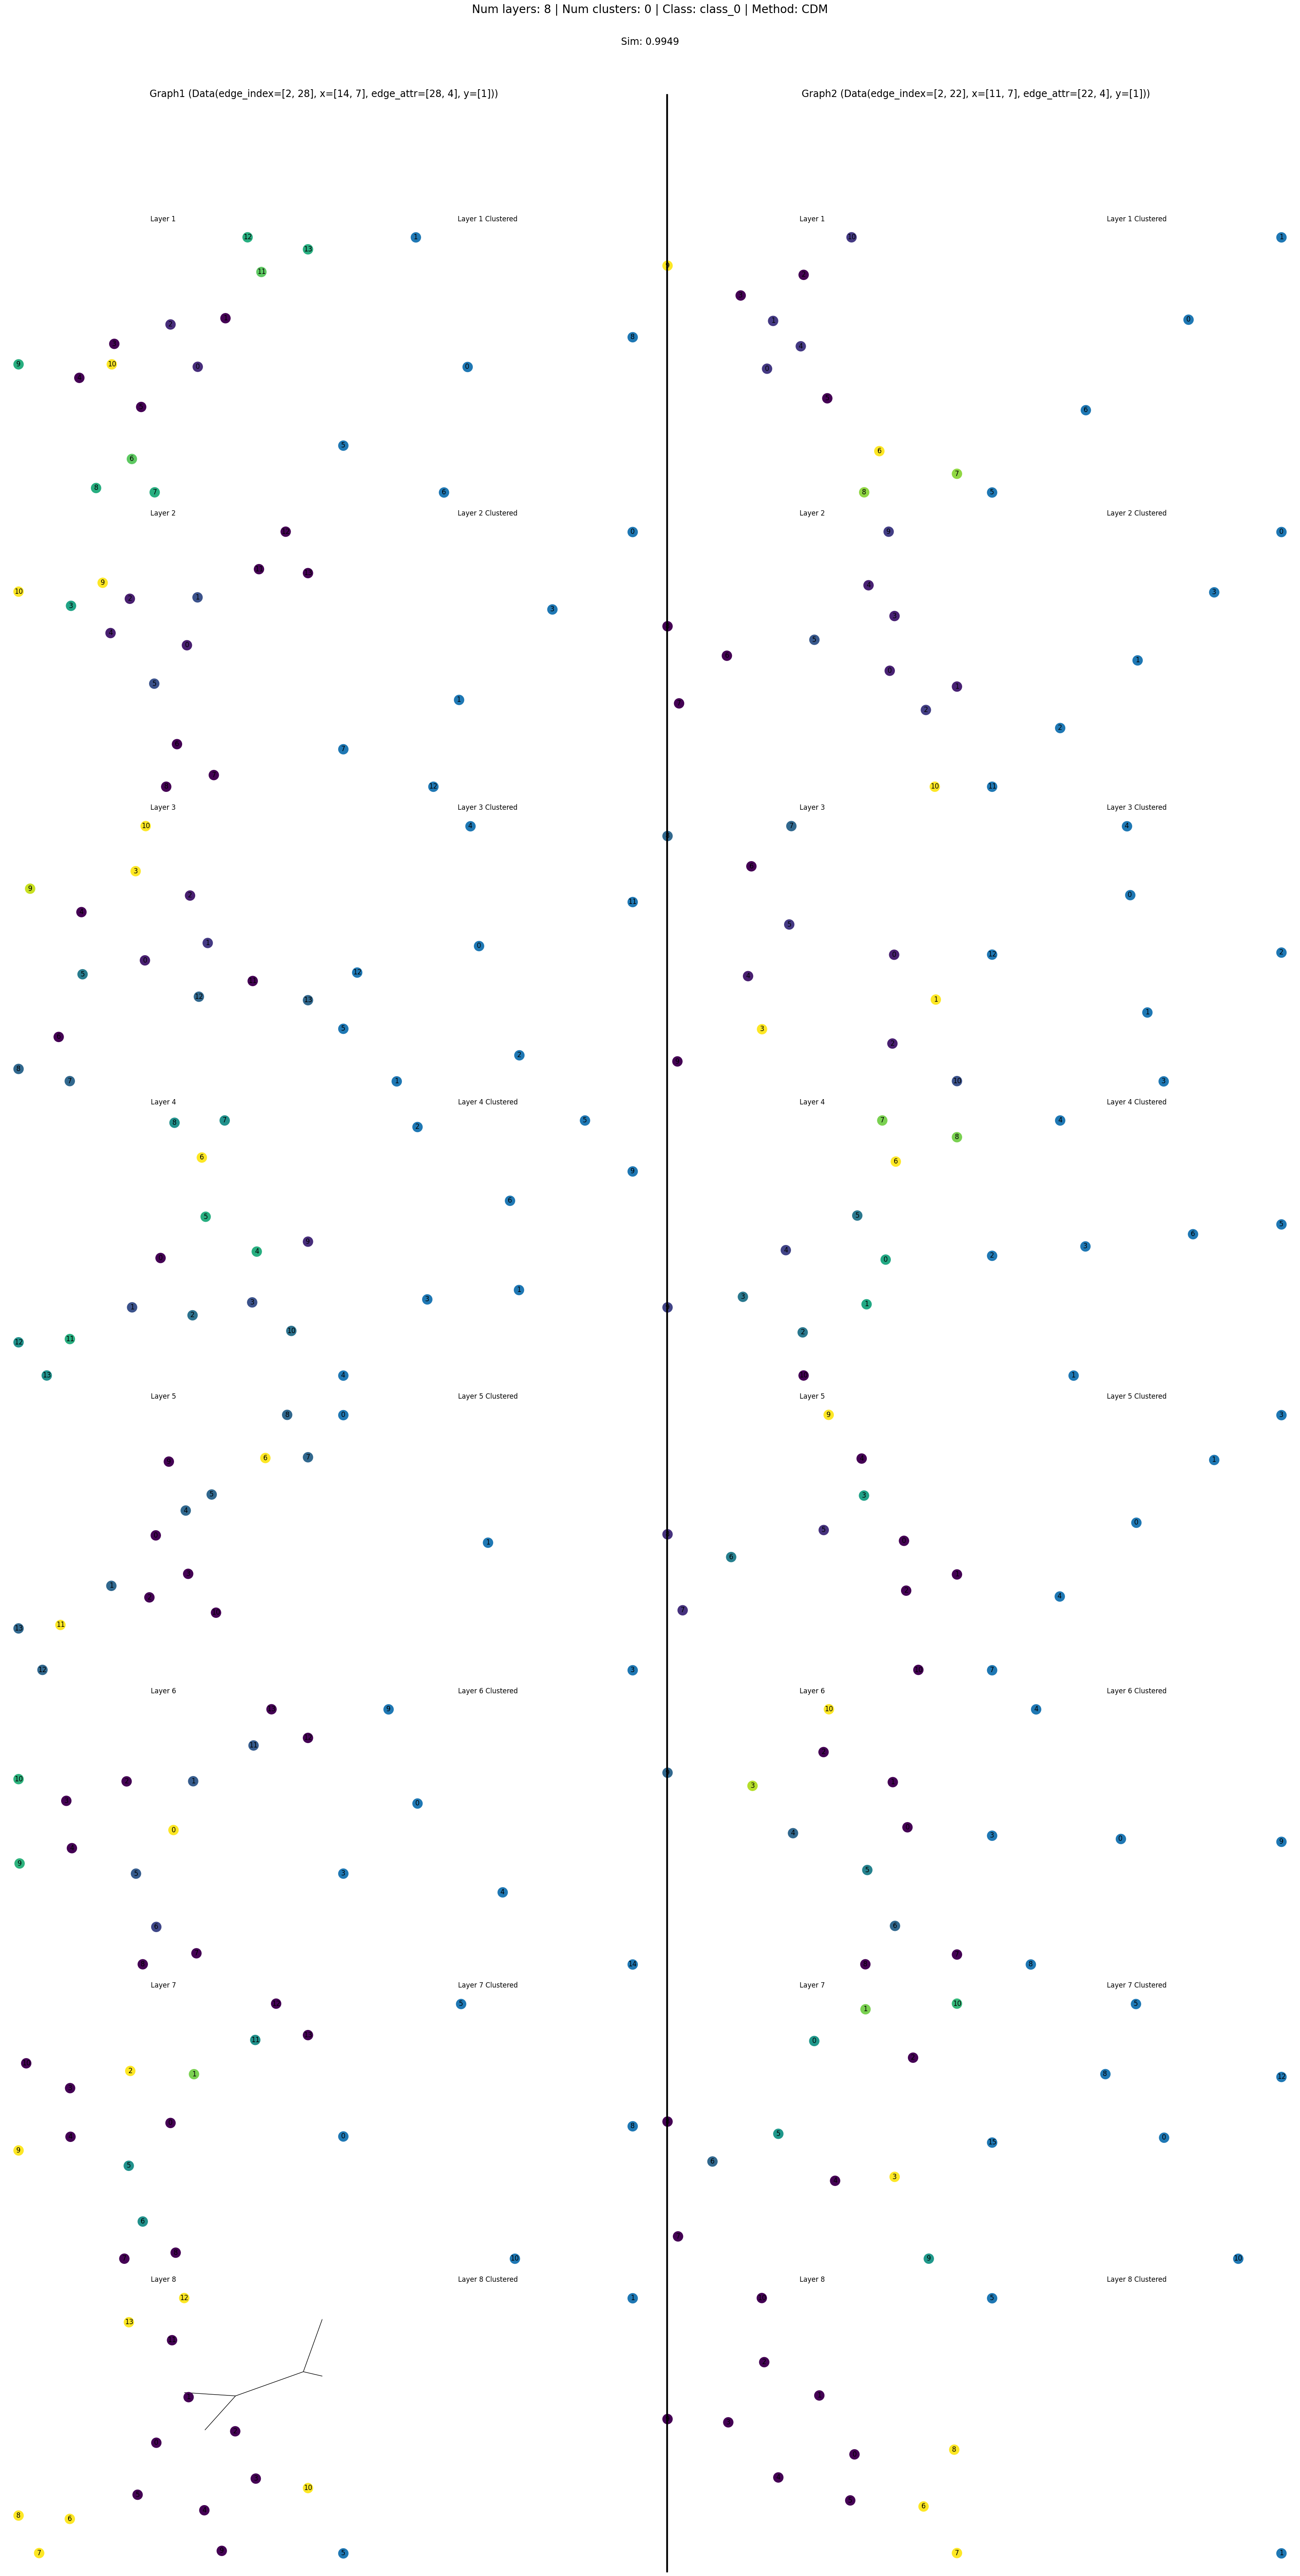

0.9737093448638916










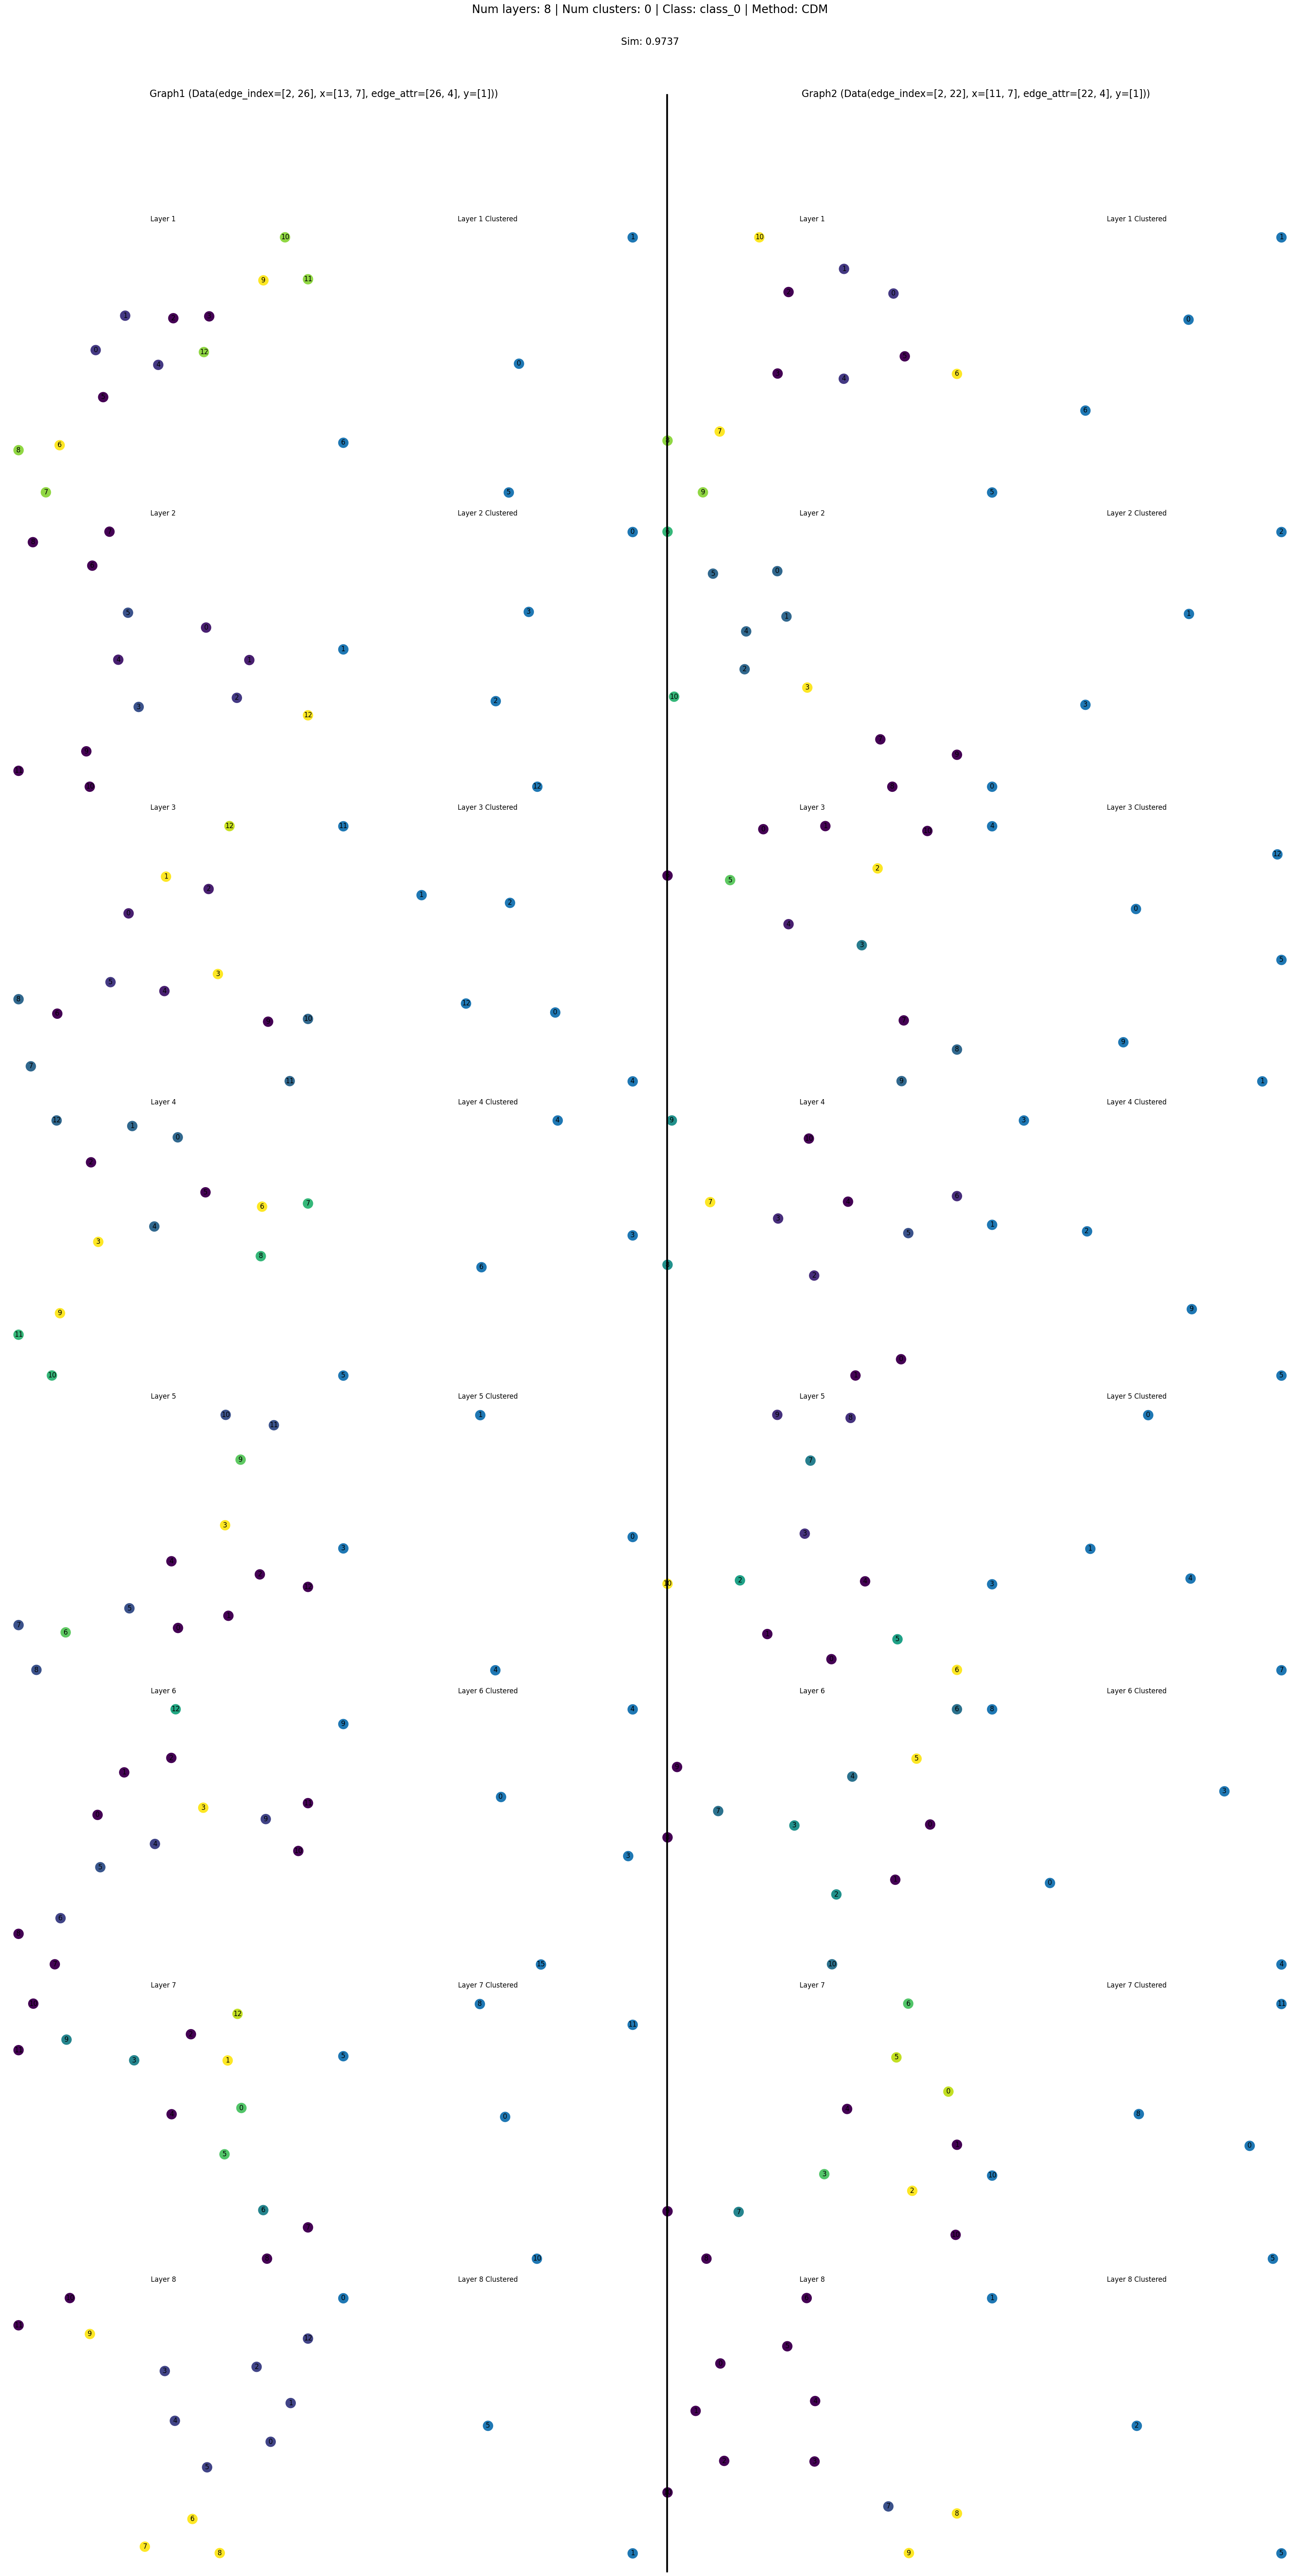

0.975378155708313










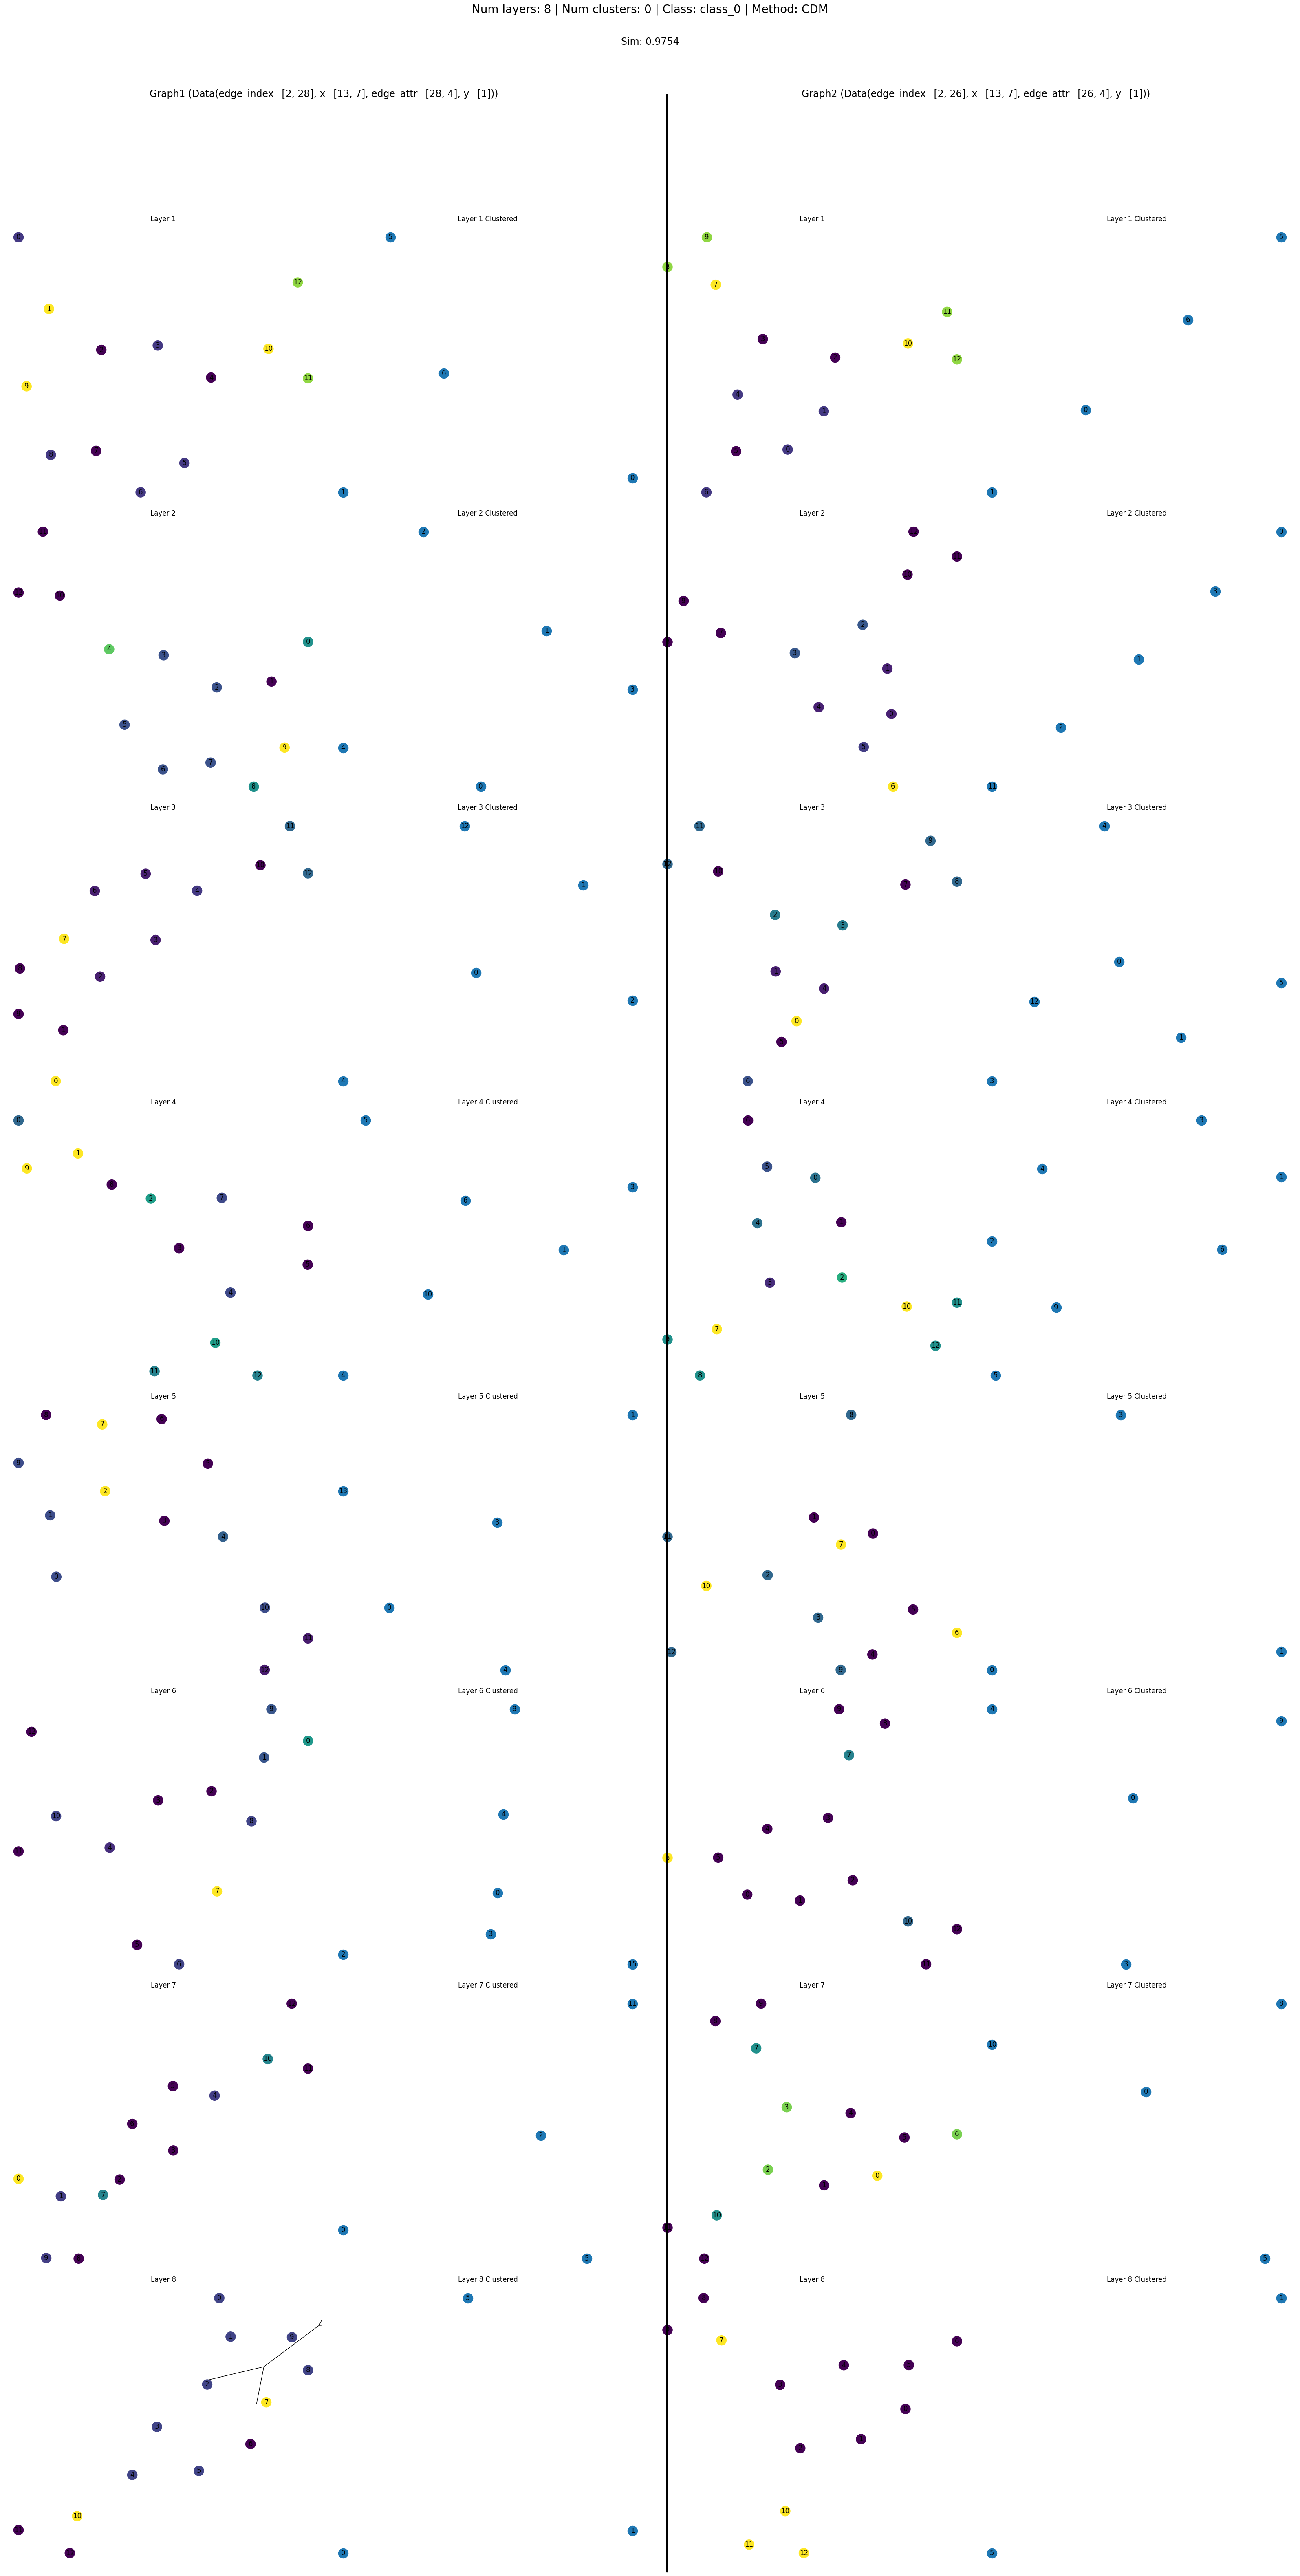

0.998458743095398










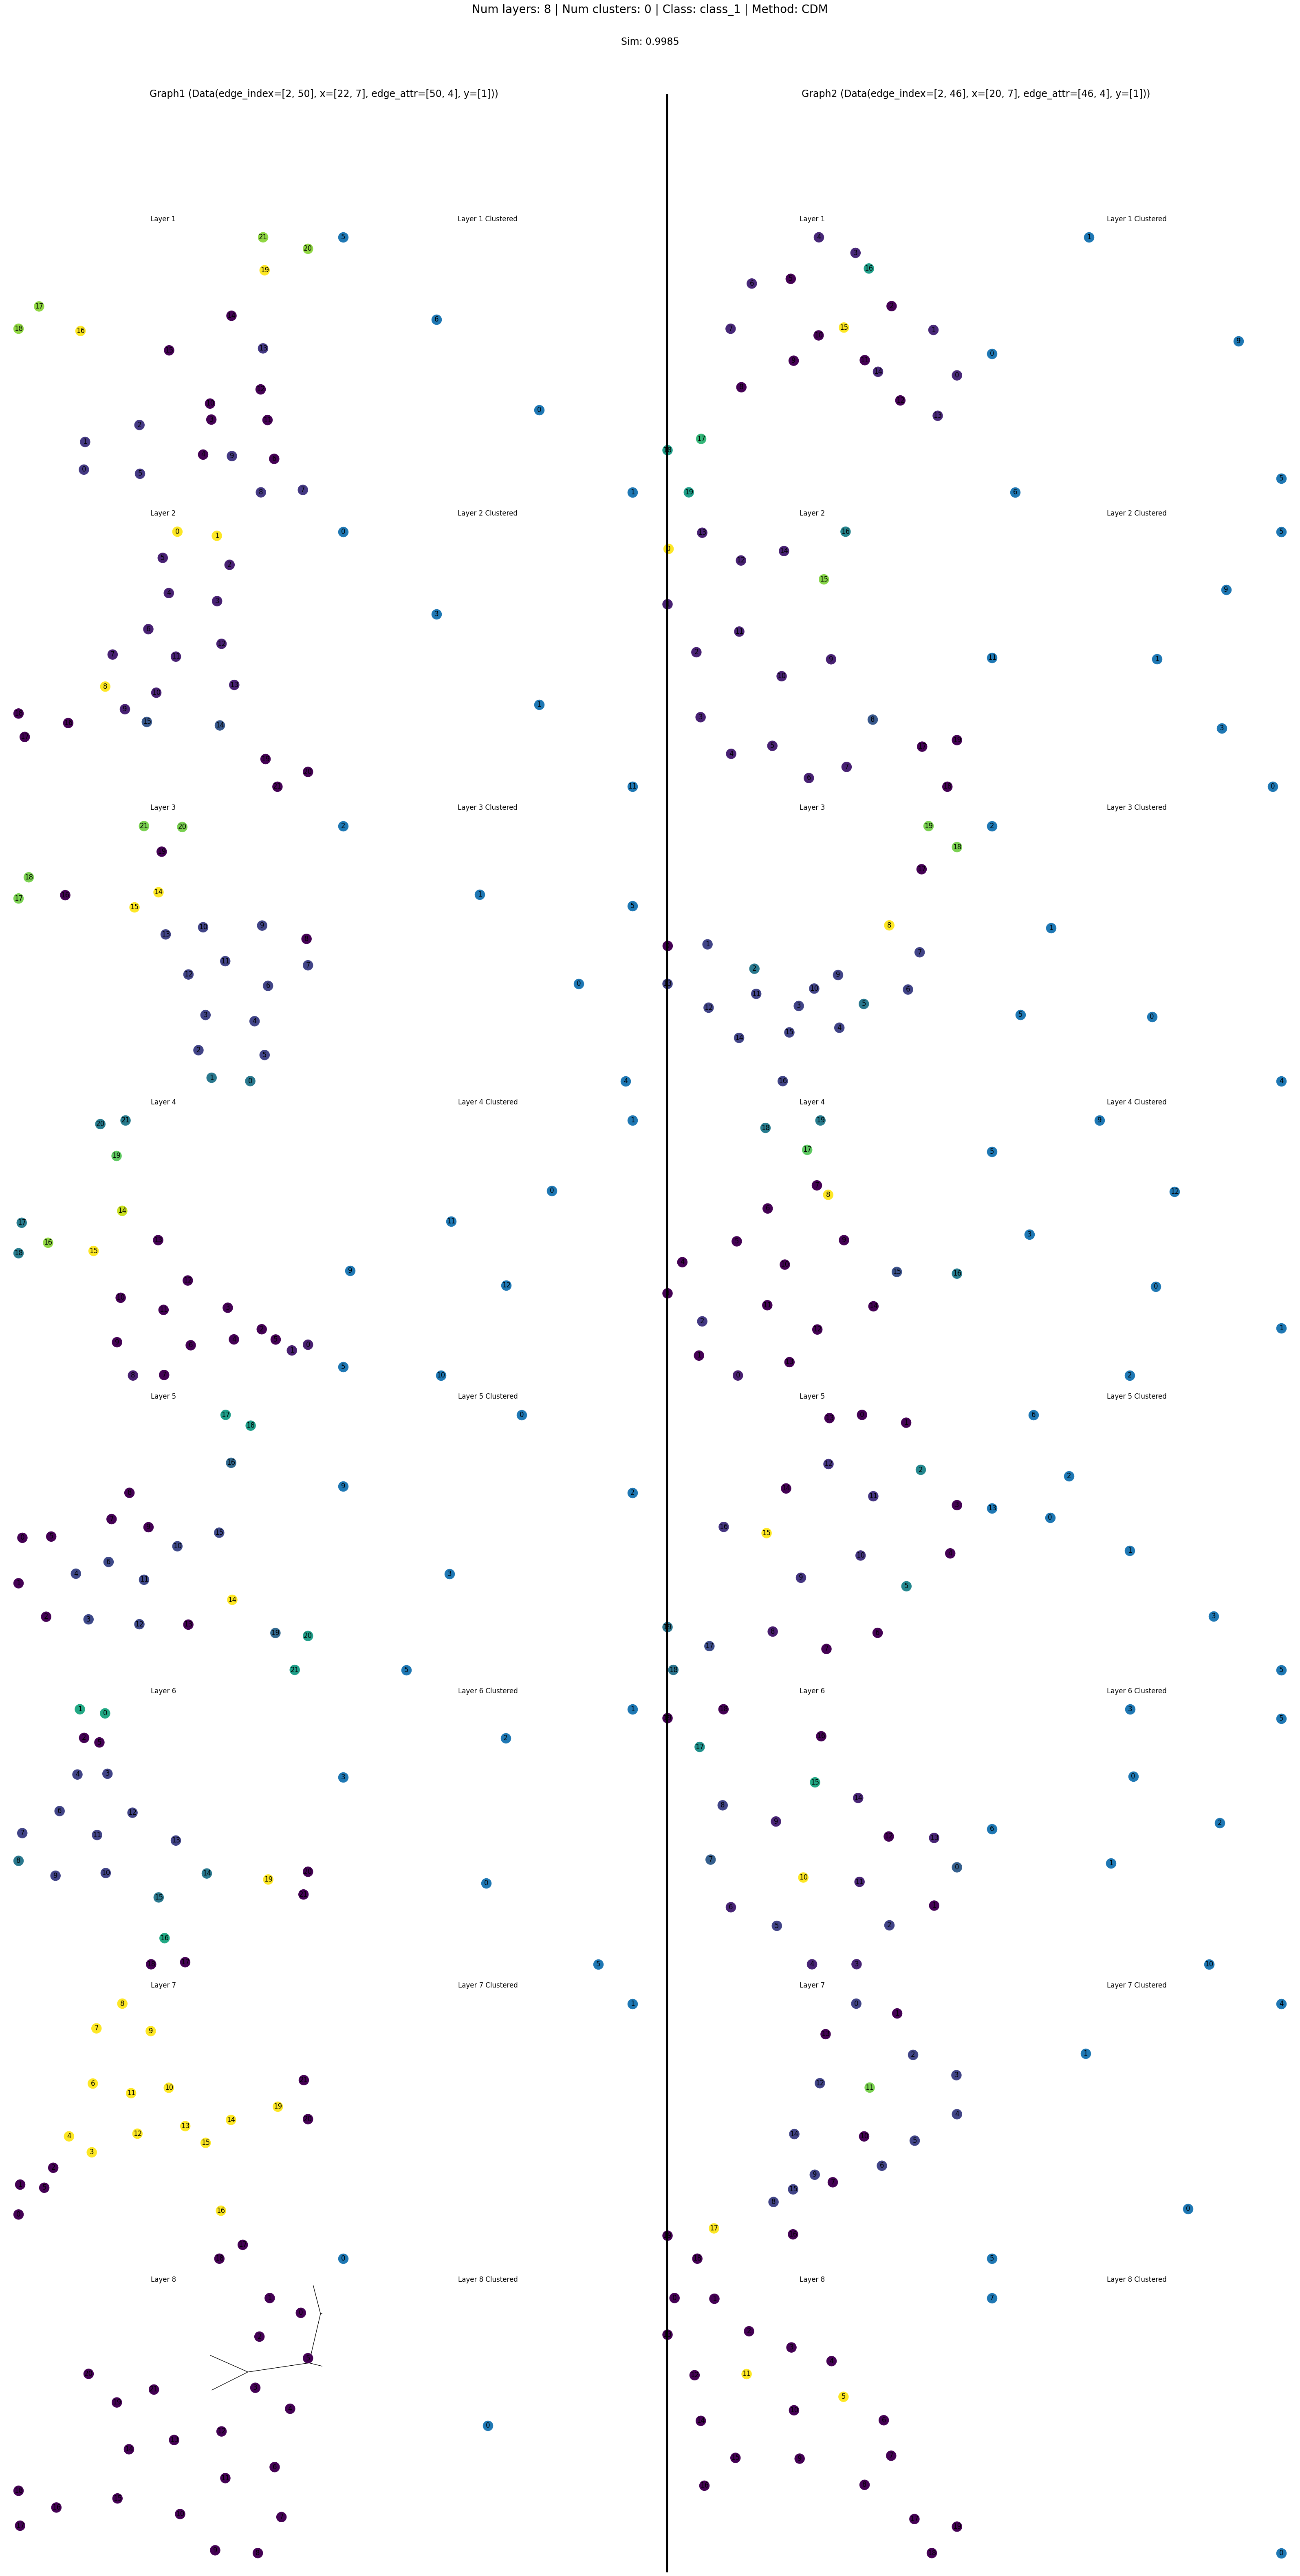

0.990153968334198










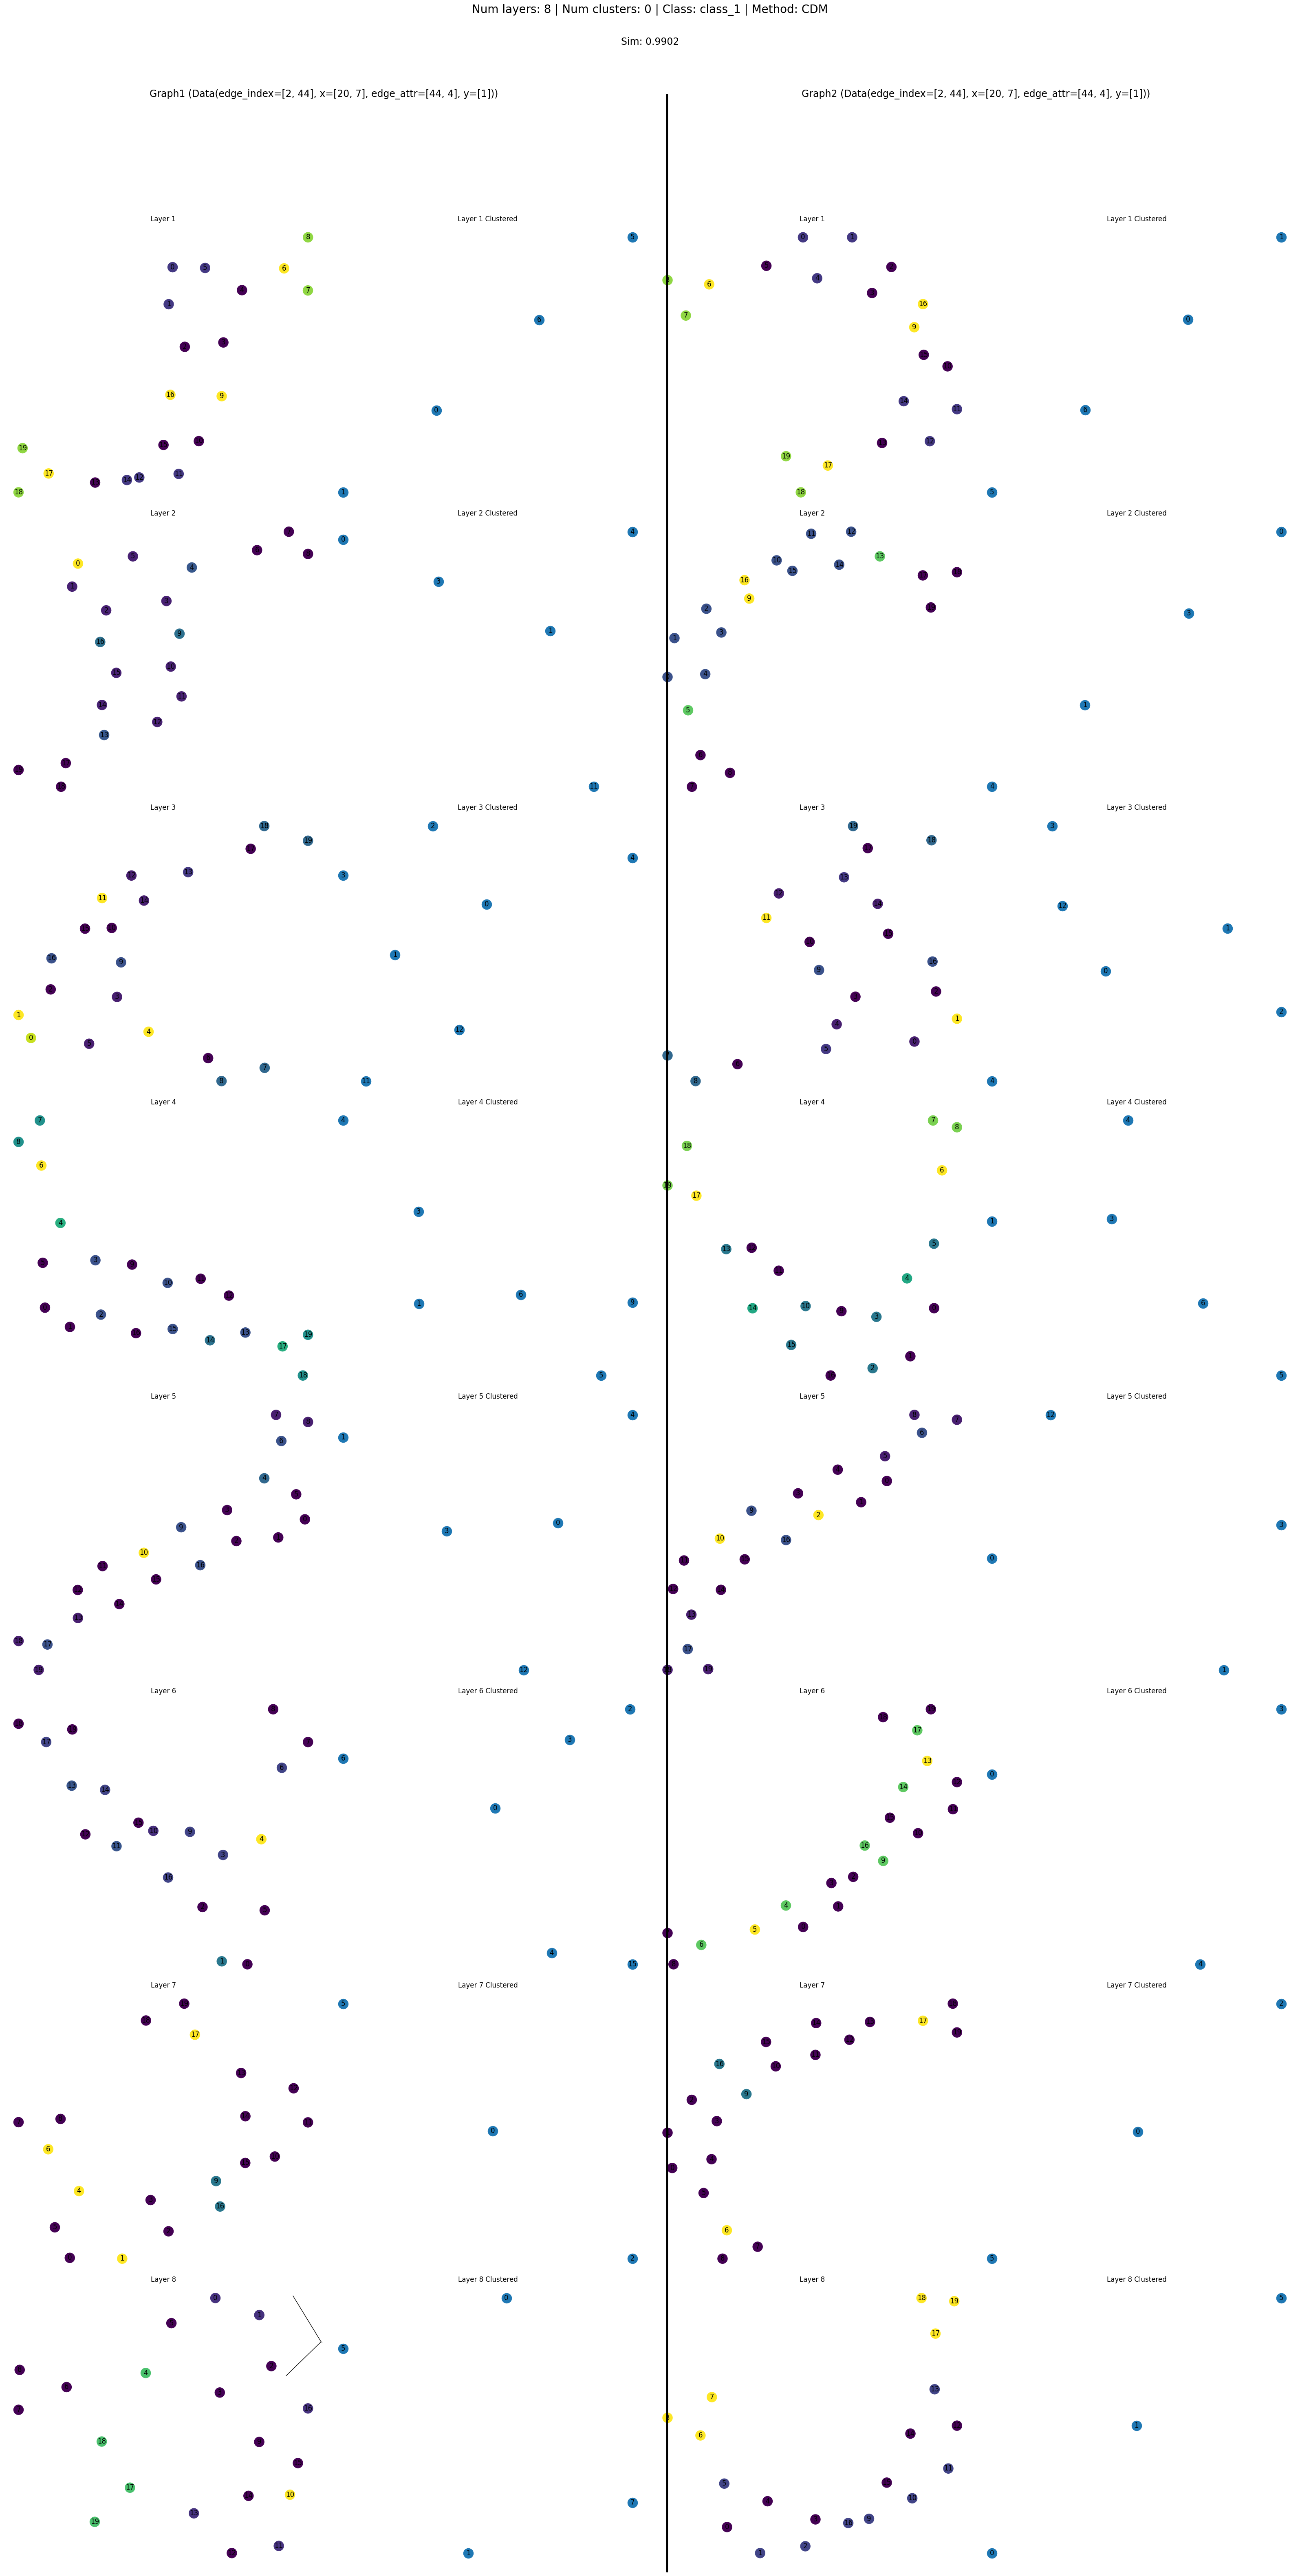

0.9959179162979126










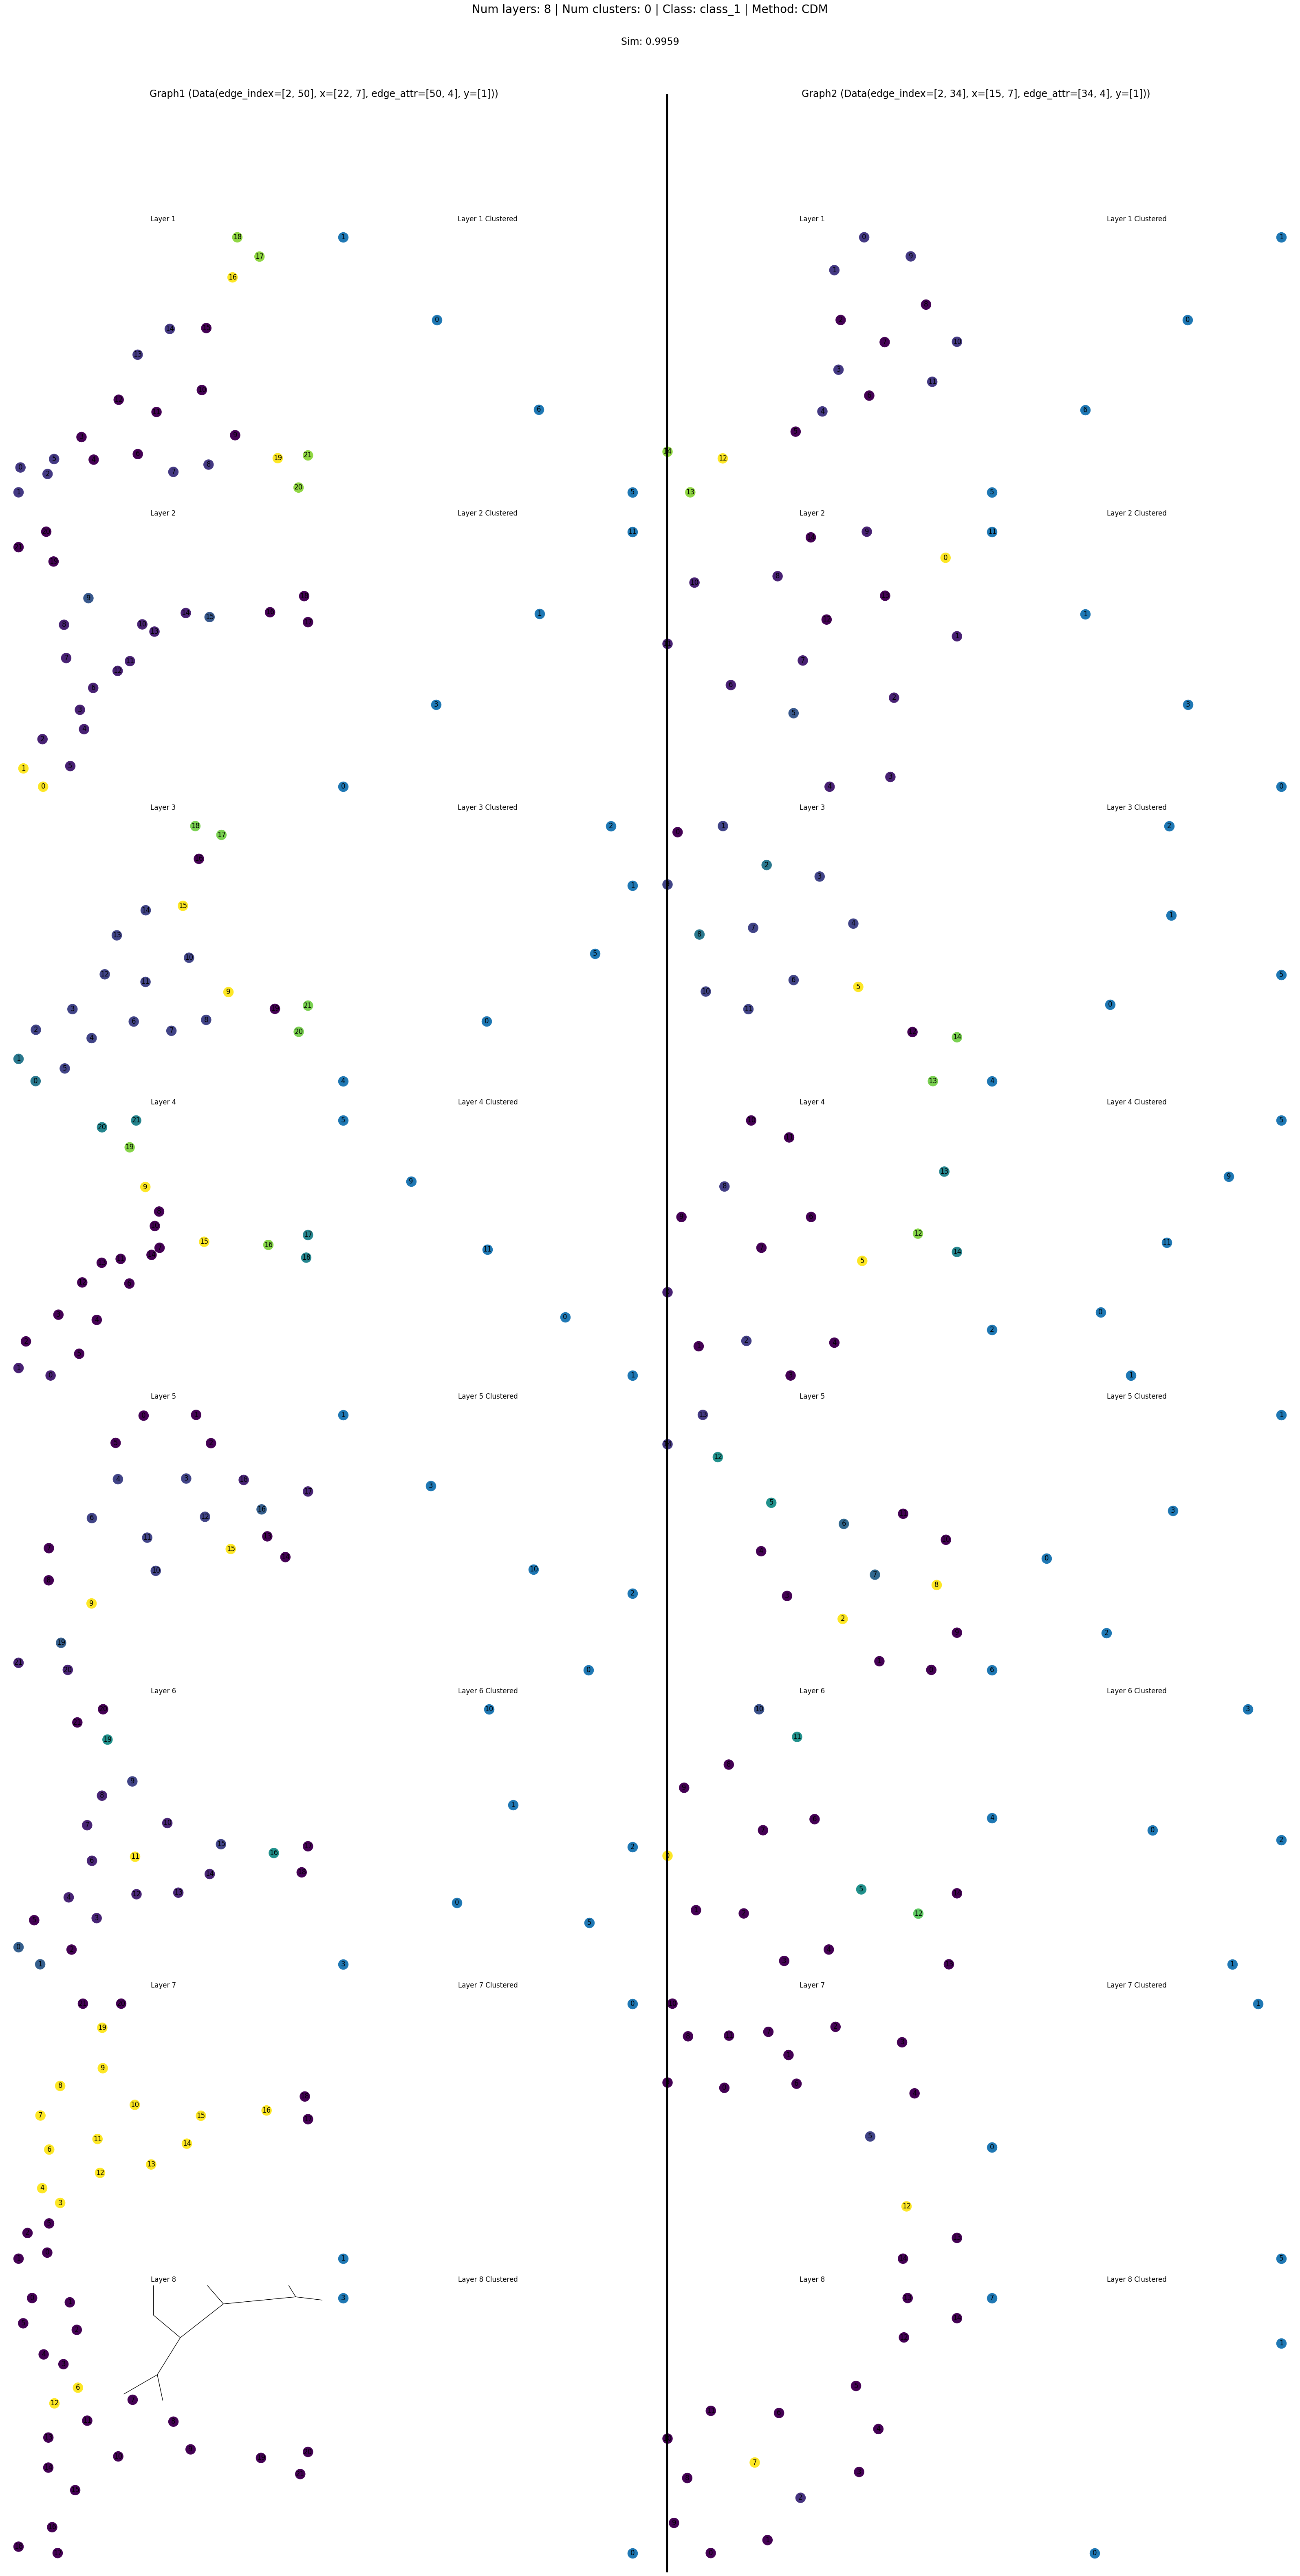

0.9728296399116516










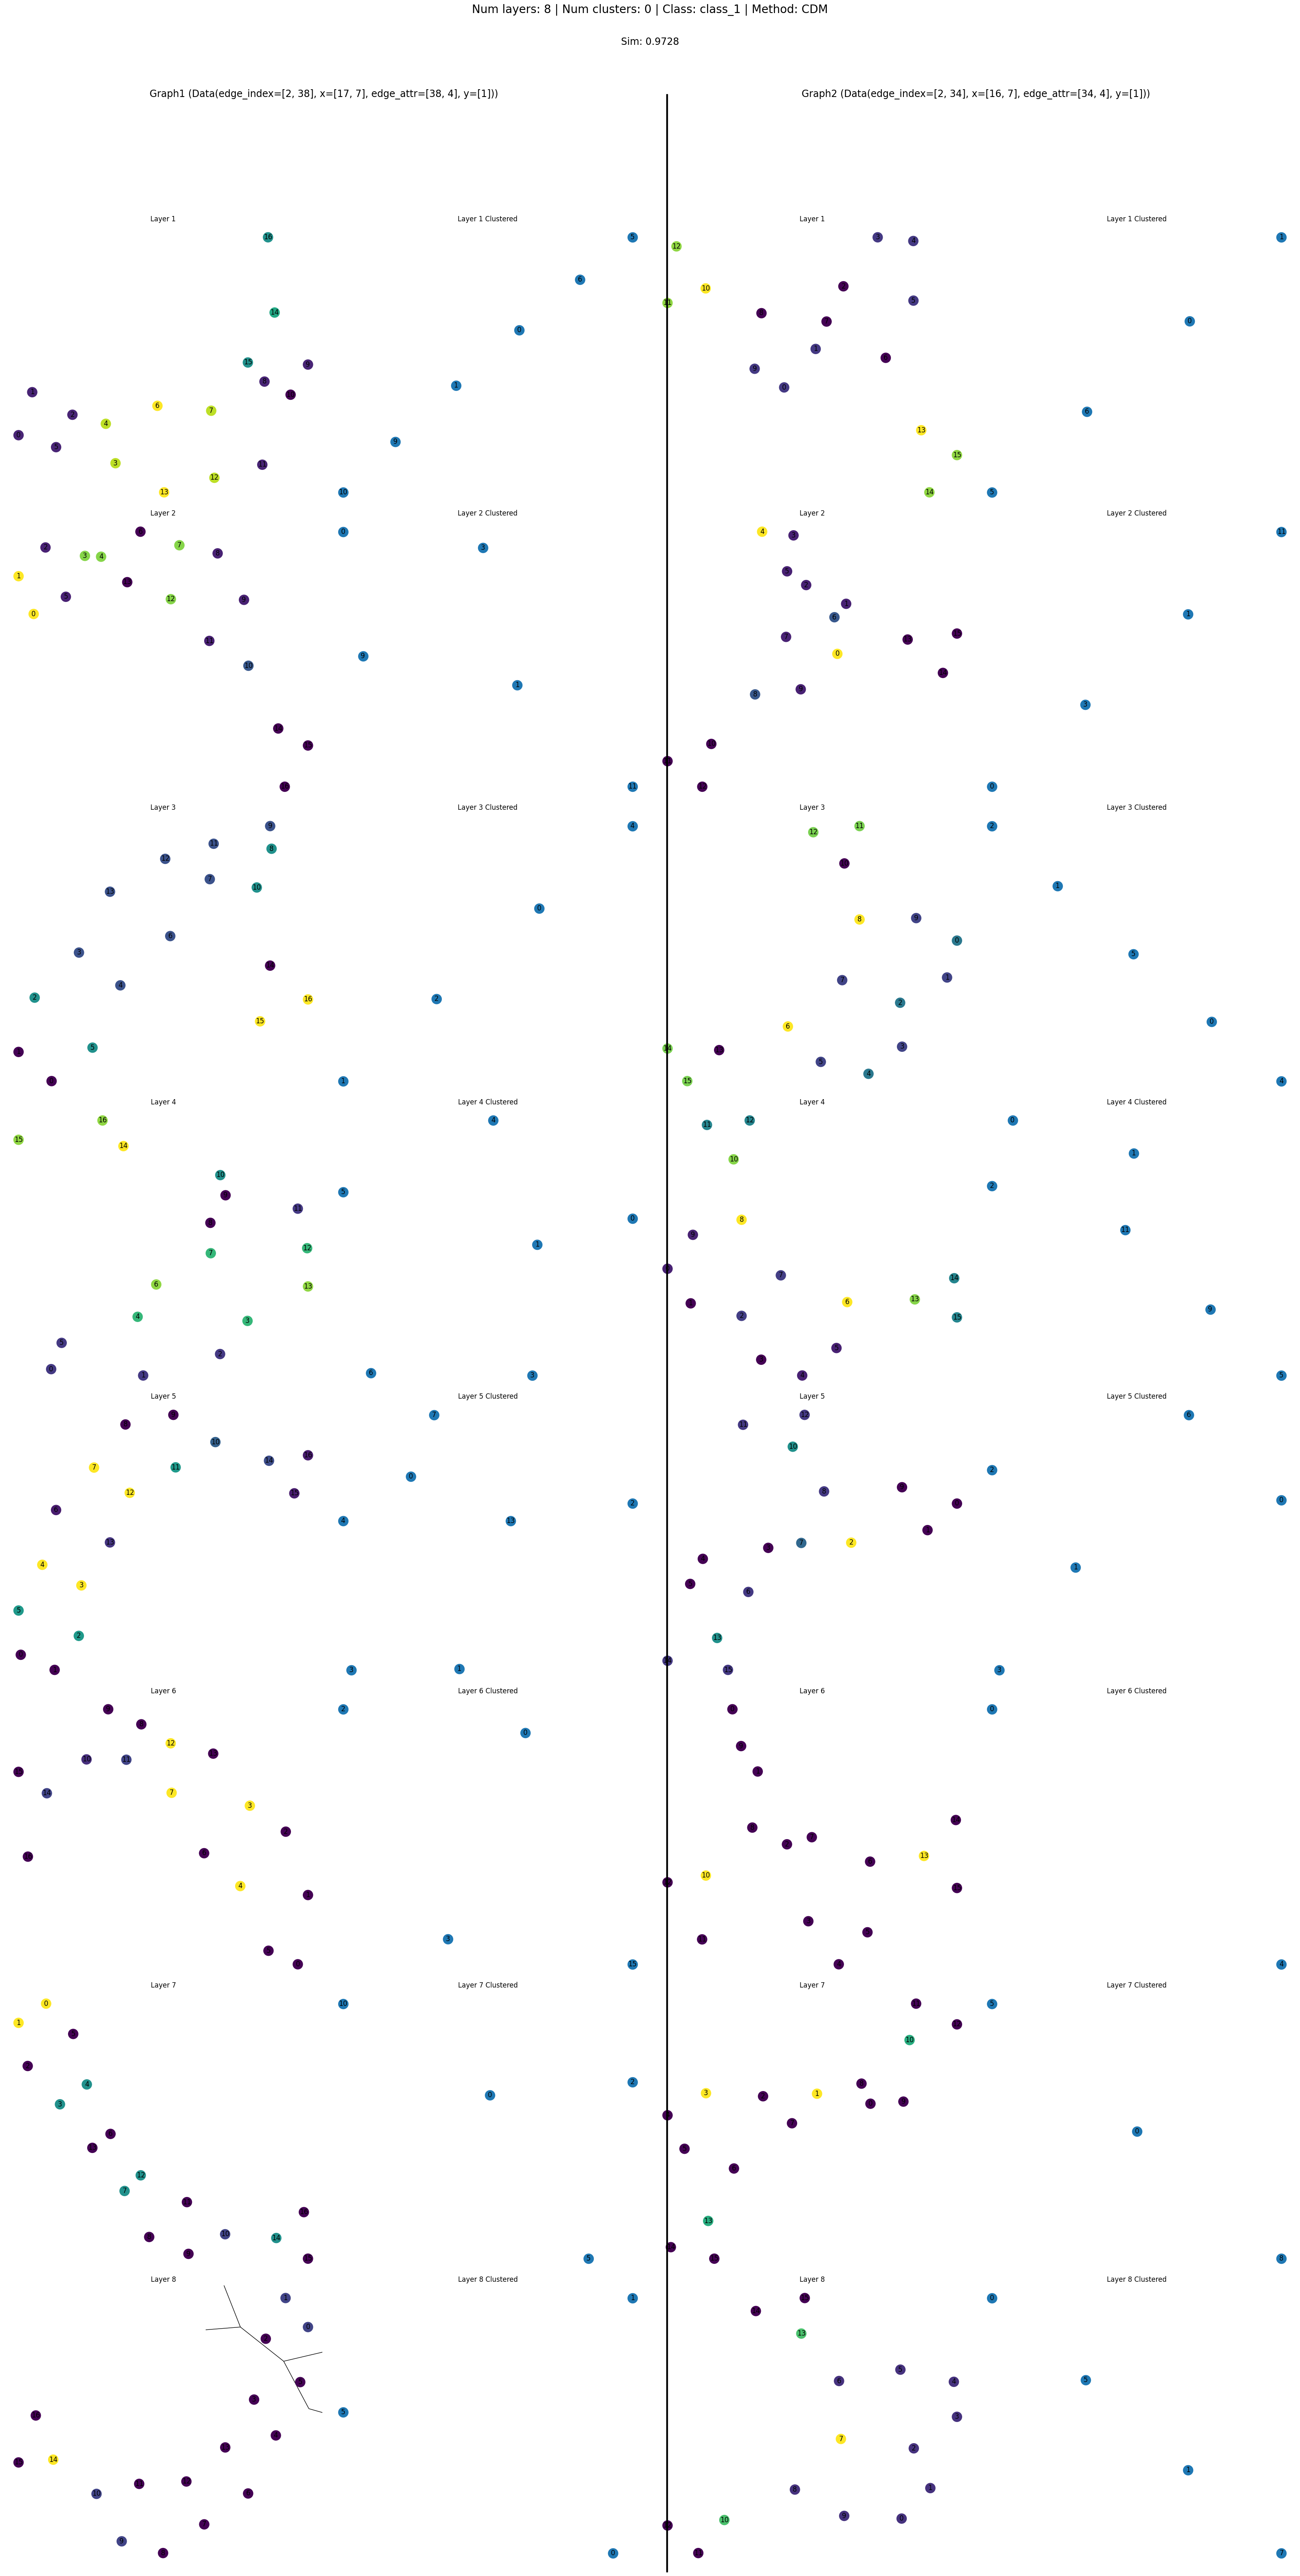

0.9208778142929077










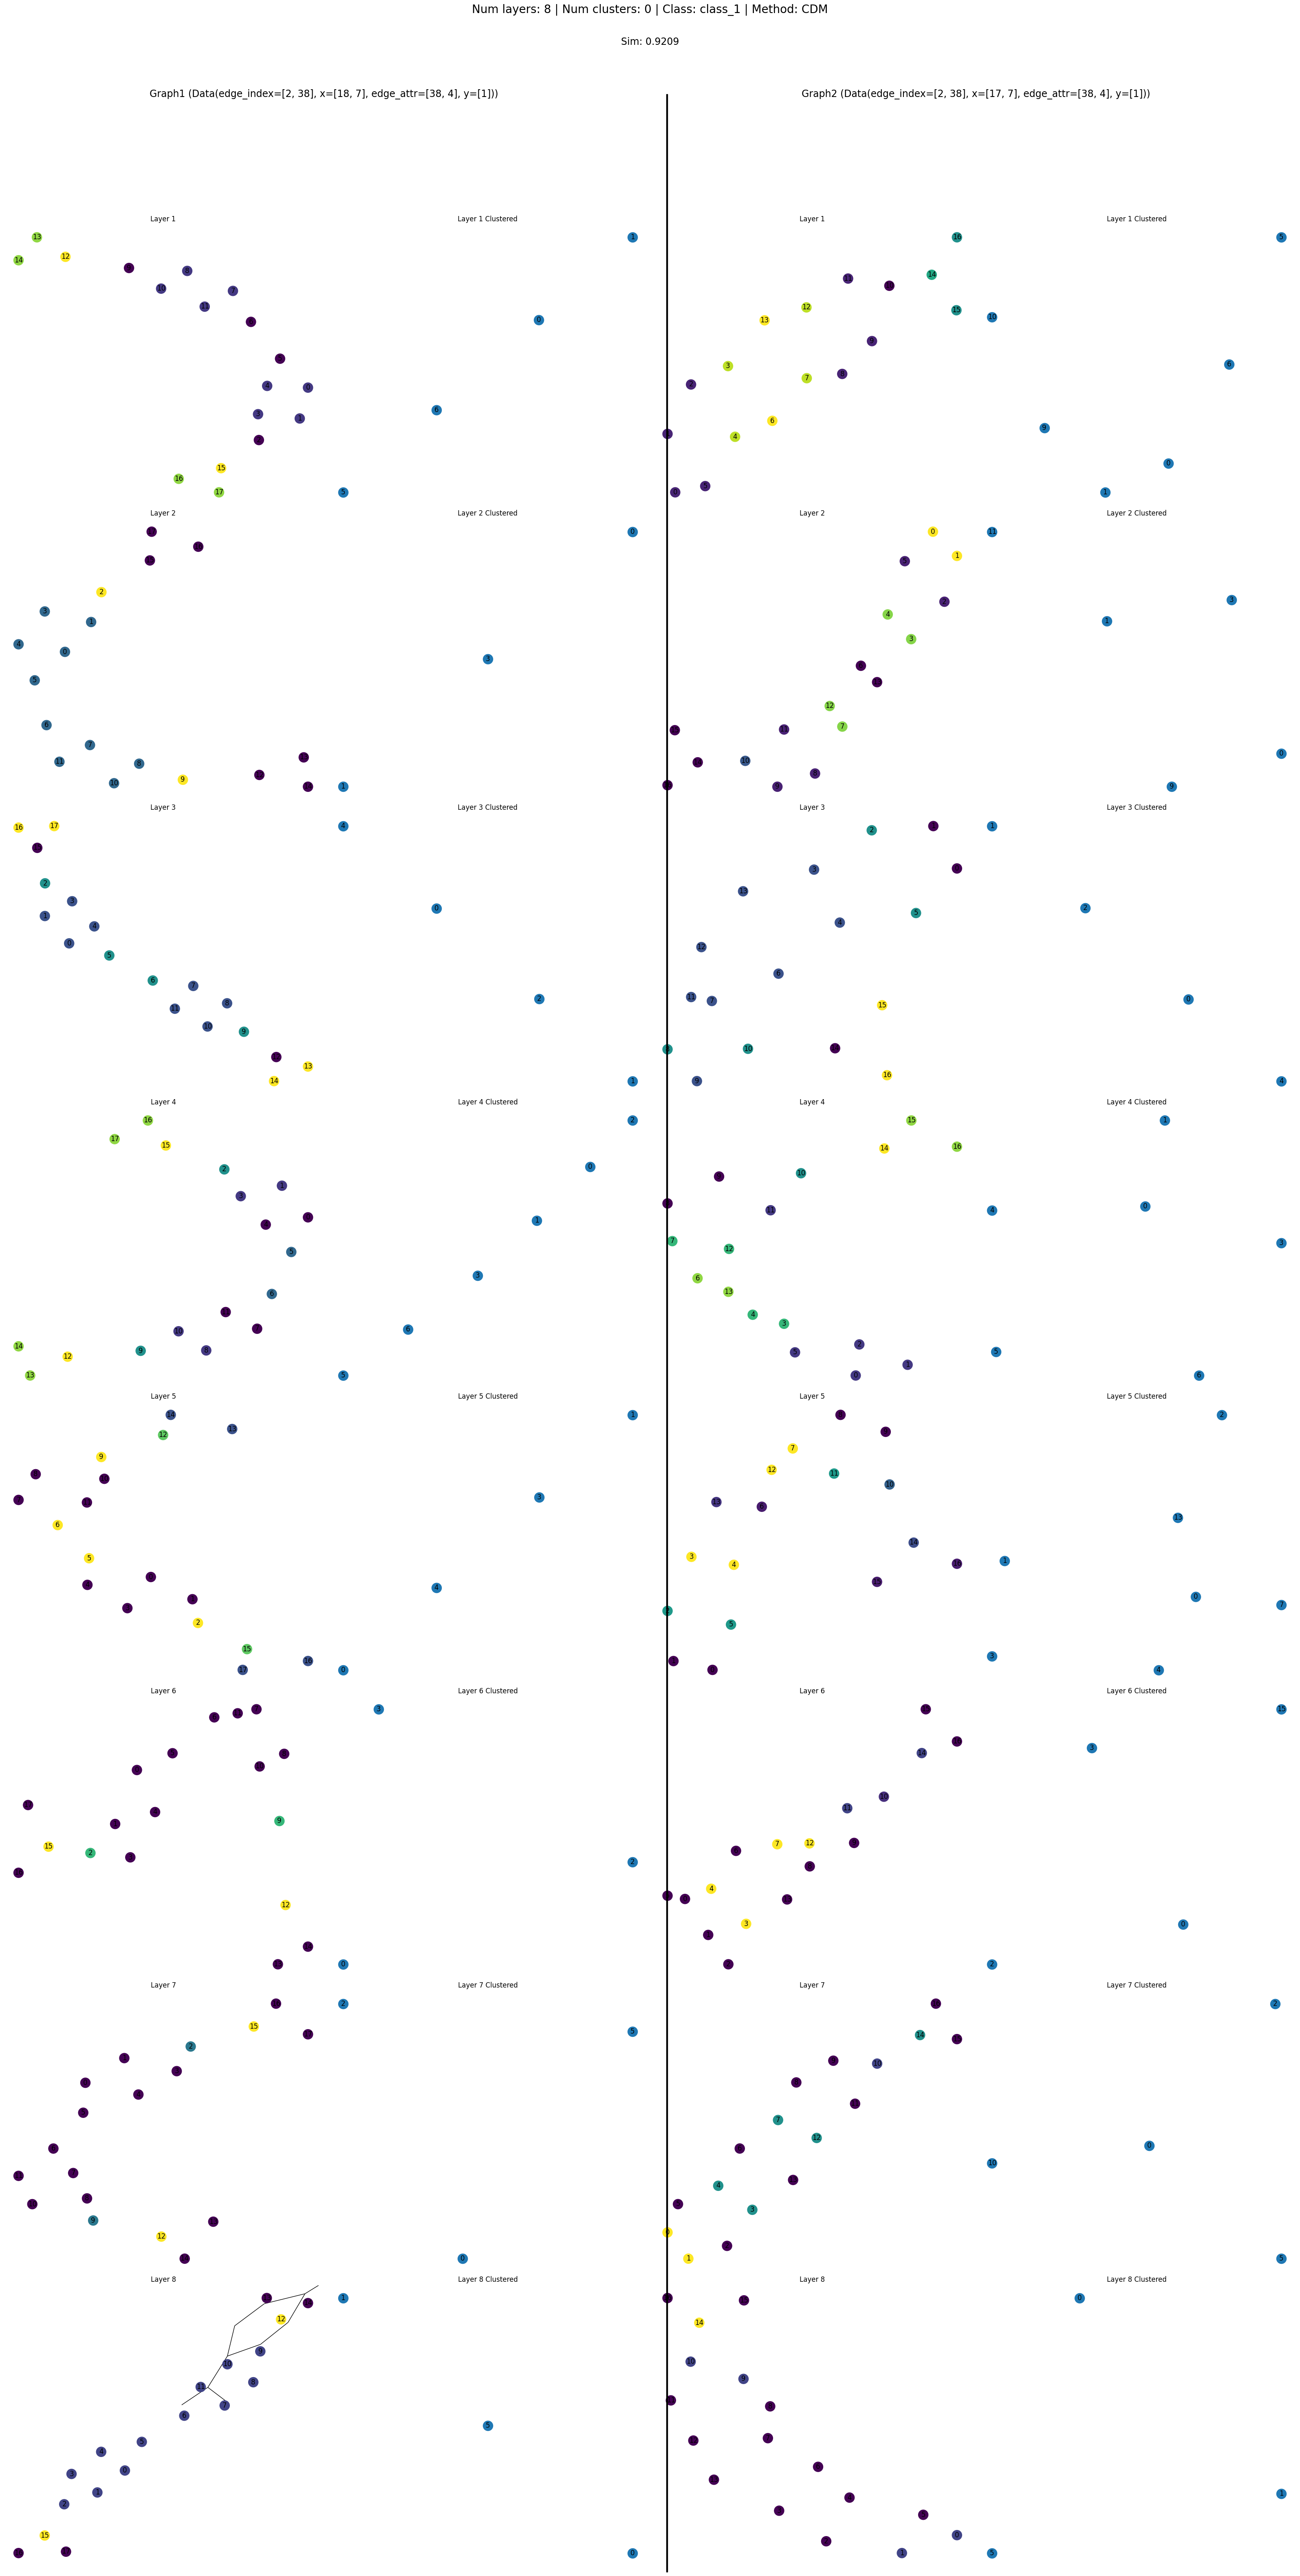

In [34]:
model.eval()

for n in [0]:
    kmeans = KMeans(n_clusters=n, n_init=n)
    agglomerative = AgglomerativeClustering(n_clusters=n)
    for c in ["class_0", "class_1"]:
        for _ in range(5):
            idx1, idx2 = random.sample(range(len(classes[c])), 2)
            graph1, graph2 = classes[c][idx1], classes[c][idx2]
            
            model.eval()

            label = 1 if graph1.y == graph2.y else -1

            feats_1, edge_index_1 = graph1.x, graph1.edge_index
            feats_2, edge_index_2 = graph2.x, graph2.edge_index
            sizes_1 = torch.tensor([len(graph1.x)])
            sizes_2 = torch.tensor([len(graph2.x)])
            emb1, emb2 = model(feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2)

            sim = cosine_similarity(emb1, emb2)[0]
            print(sim.item())
                        
            g1_embeddings = torch.stack([t[0] for t in model.layer_outputs])
            g2_embeddings = torch.stack([t[1] for t in model.layer_outputs])
            
            mean_g1 = torch.mean(g1_embeddings, dim=0)
            mean_g2 = torch.mean(g2_embeddings, dim=0)
            
            agglomerative_clusters = []
            kmeans_clusters = []
            cdm_clusters = []
            # for o1, o2 in model.layer_outputs:
            for o1, o2 in model.layer_outputs:
                # agglomerative_cluster1 = torch.tensor(agglomerative.fit_predict(o1.detach().numpy().reshape(-1, 1)))
                # agglomerative_cluster2 = torch.tensor(agglomerative.fit_predict(o2.detach().numpy().reshape(-1, 1)))
                # agglomerative_clusters.append((agglomerative_cluster1, agglomerative_cluster2))
                # kmeans_cluster1 = torch.tensor(kmeans.fit_predict(o1.detach().numpy().reshape(-1, 1)))
                # kmeans_cluster2 = torch.tensor(kmeans.fit_predict(o2.detach().numpy().reshape(-1, 1)))
                # kmeans_clusters.append((kmeans_cluster1, kmeans_cluster2))
                cdm_cluster1 = cdm(o1)
                cdm_cluster2 = cdm(o2)
                cdm_clusters.append((cdm_cluster1, cdm_cluster2))
            
            title = f"Num layers: {args.num_layers} | Num clusters: {n} | Class: {c} | Method: "
                
            plot_graphs([graph1.edge_index, graph2.edge_index], cdm_clusters, graph1, graph2, sim, title+"CDM")
            # plot_graphs([graph1.edge_index, graph2.edge_index], agglomerative_clusters, graph1, graph2, sim, title+"Agglomerative")
            # plot_graphs([graph1.edge_index, graph2.edge_index], kmeans_clusters, graph1, graph2, sim, title+"KMeans")

In [ ]:
idx1, idx2 = random.sample(range(len(classes[c])), 2)
graph1, graph2 = classes[c][idx1], classes[c][idx2]

model.eval()

label = 1 if graph1.y == graph2.y else -1

feats_1, edge_index_1 = graph1.x, graph1.edge_index
feats_2, edge_index_2 = graph2.x, graph2.edge_index
sizes_1 = torch.tensor([len(graph1.x)])
sizes_2 = torch.tensor([len(graph2.x)])
emb1, emb2 = model(feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2)

sim = cosine_similarity(emb1, emb2)[0]
print(sim.item())
            
g1_embeddings = torch.stack([t[0] for t in model.layer_outputs])
g2_embeddings = torch.stack([t[1] for t in model.layer_outputs])

mean_g1 = torch.mean(g1_embeddings, dim=0)
mean_g2 = torch.mean(g2_embeddings, dim=0)

agglomerative_clusters = []
kmeans_clusters = []
cdm_clusters = []
for o1, o2 in model.layer_outputs:
    cdm_cluster1 = cdm(o1)
    cdm_cluster2 = cdm(o2)
    cdm_clusters.append((cdm_cluster1, cdm_cluster2))
    
print(cdm_clusters)

title = f"Num layers: {args.num_layers} | Num clusters: {n} | Class: {c} | Method: "
    
plot_graphs([graph1.edge_index, graph2.edge_index], cdm_clusters, graph1, graph2, sim, title+"CDM")

In [36]:
idx1, idx2 = random.sample(range(len(classes["class_0"])), 2)
graph1, graph2 = classes["class_0"][idx1], classes["class_0"][idx2]

model.eval()

label = 1 if graph1.y == graph2.y else -1

feats_1, edge_index_1 = graph1.x, graph1.edge_index
feats_2, edge_index_2 = graph2.x, graph2.edge_index
sizes_1 = torch.tensor([len(graph1.x)])
sizes_2 = torch.tensor([len(graph2.x)])
emb1, emb2 = model(feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2)

sim = cosine_similarity(emb1, emb2)[0]
            
g1_embeddings = torch.stack([t[0] for t in model.layer_outputs])
g2_embeddings = torch.stack([t[1] for t in model.layer_outputs])

mean_g1 = torch.mean(g1_embeddings, dim=0)
mean_g2 = torch.mean(g2_embeddings, dim=0)

clusters = []

for o1, o2 in model.layer_outputs:
    cdm_cluster1 = cdm(o1)
    cdm_cluster2 = cdm(o2)
    
    clusters.append((cdm_cluster1, cdm_cluster2))

In [37]:
G1 = nx.Graph()
G1.add_edges_from(edge_index_1.t().tolist())
supernode_mapping1 = {node: int(cls) for node, cls in enumerate(clusters[0][0])}
supergraph1 = nx.Graph()
for cls in torch.unique(clusters[0][0]):
    supergraph1.add_node(cls.item())
for (n1, n2) in G1.edges():
    sn1, sn2 = supernode_mapping1[n1], supernode_mapping1[n2]
    if sn1 != sn2:
        supergraph1.add_edge(sn1, sn2)
        
G2 = nx.Graph()
G2.add_edges_from(edge_index_2.t().tolist())
supernode_mapping2 = {node: int(cls) for node, cls in enumerate(clusters[0][1])}
supergraph2 = nx.Graph()
for cls in torch.unique(clusters[0][1]):
    supergraph2.add_node(cls.item())
for (n1, n2) in G2.edges():
    sn1, sn2 = supernode_mapping2[n1], supernode_mapping2[n2]
    if sn1 != sn2:
        supergraph2.add_edge(sn1, sn2)

tensor(0.9605, grad_fn=<SelectBackward0>)



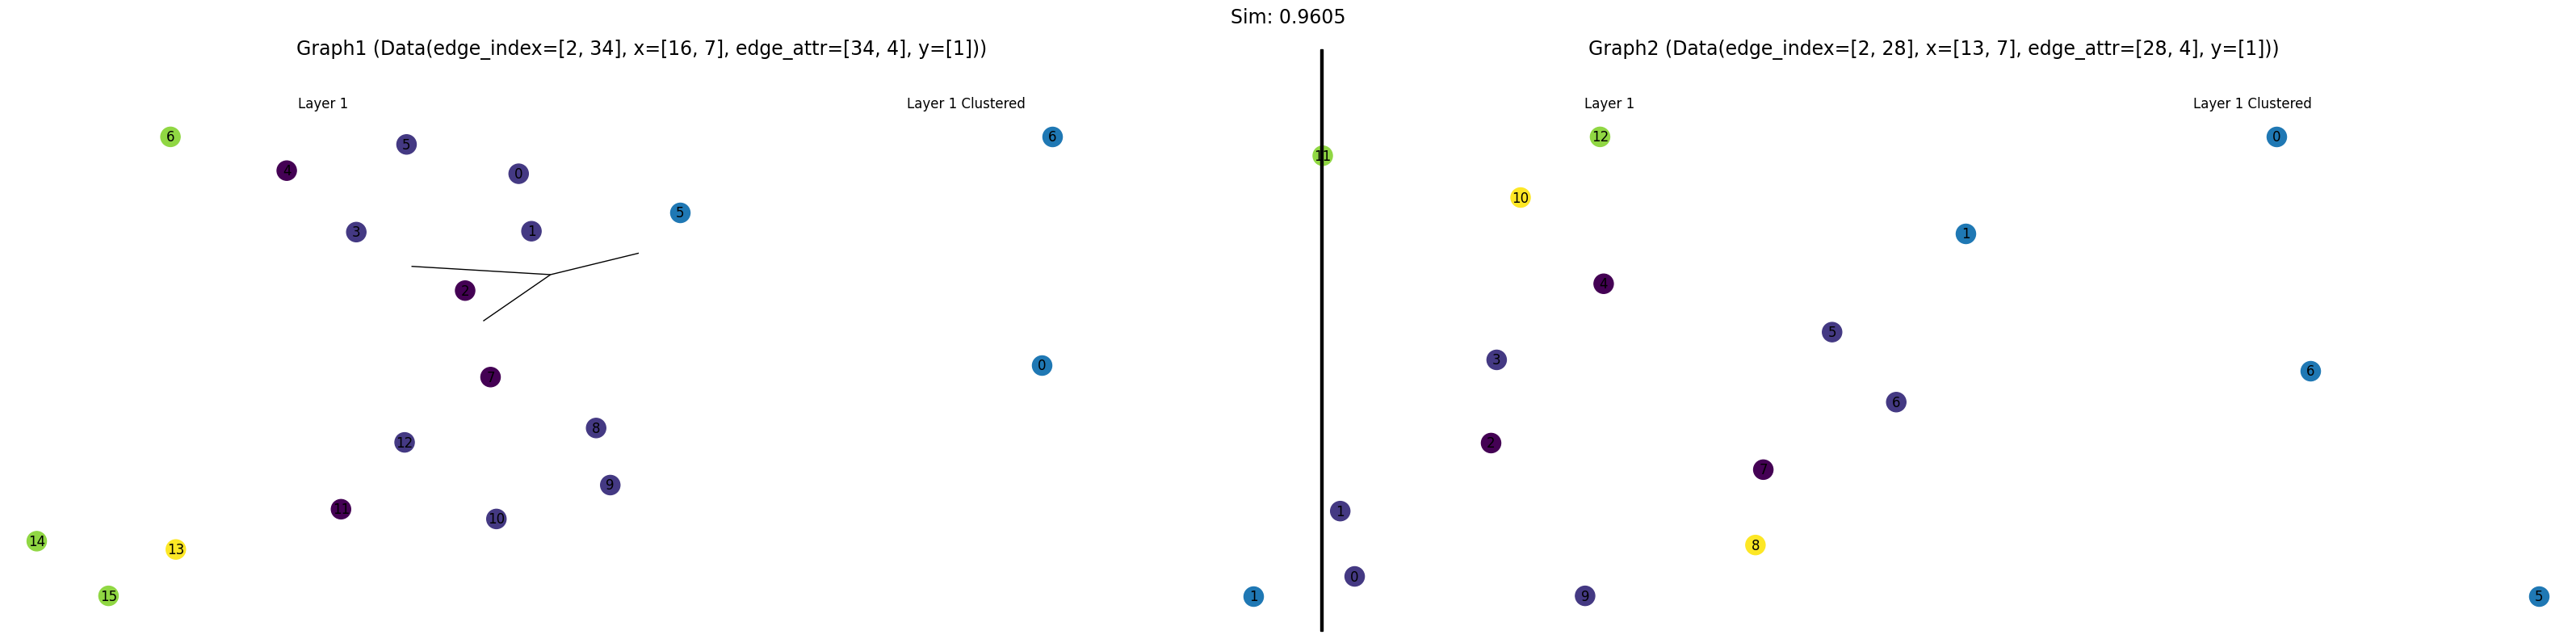

tensor(0.9996, grad_fn=<SelectBackward0>)



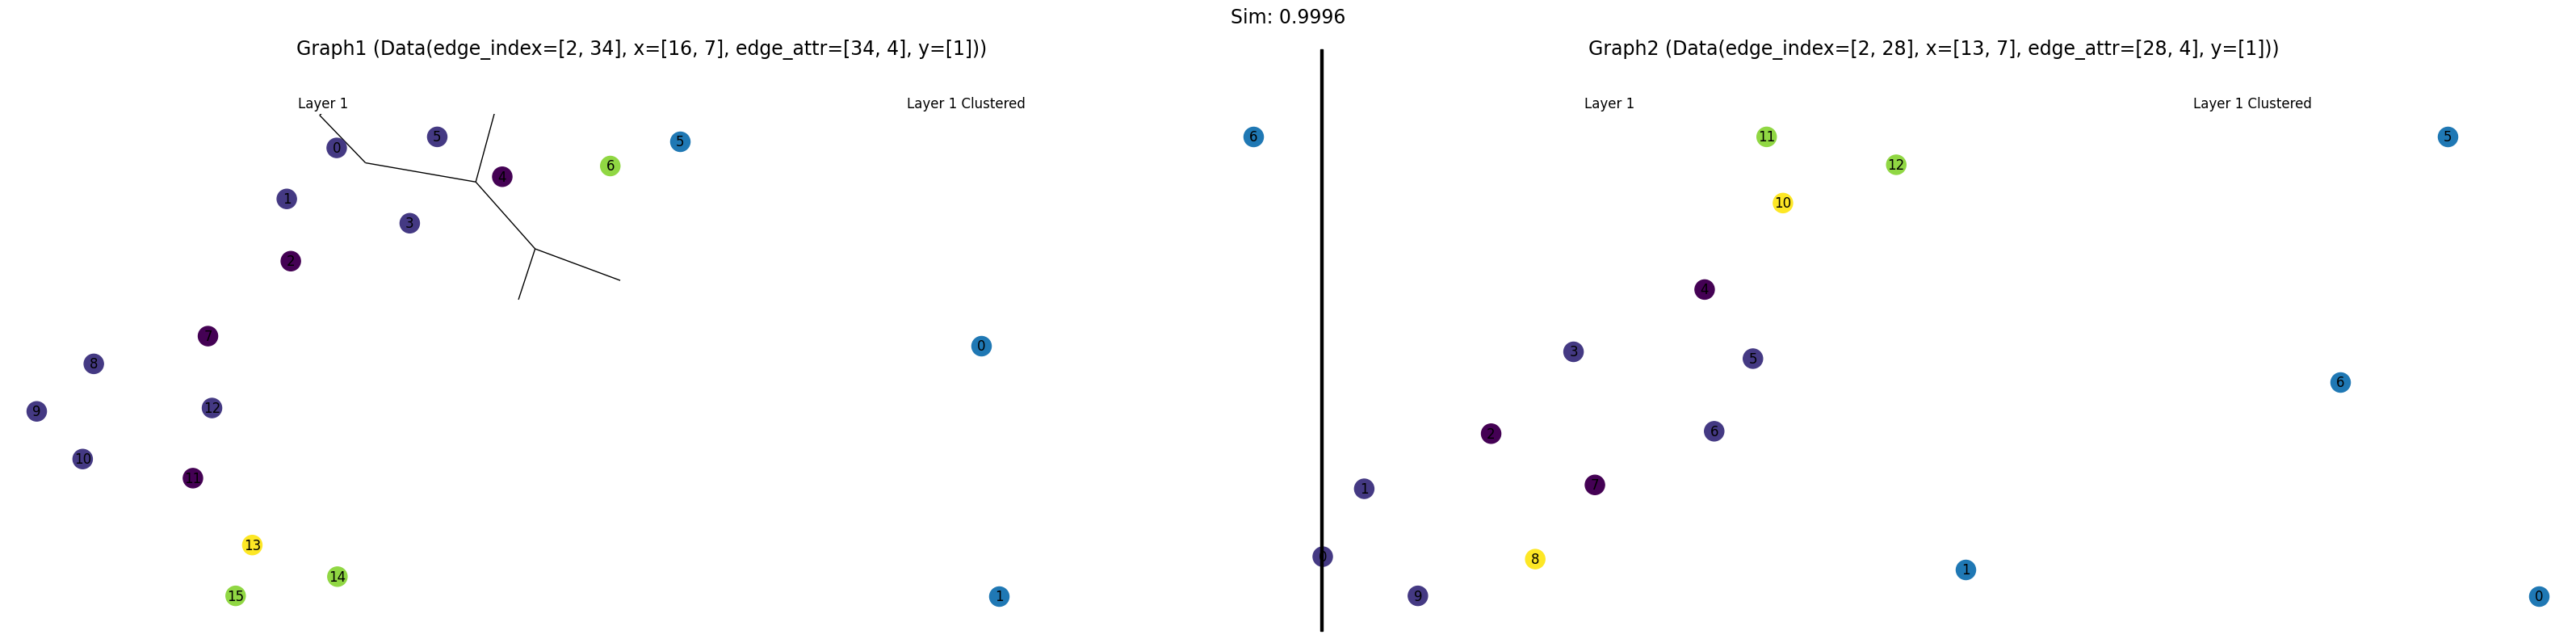

tensor(0.0776, grad_fn=<SelectBackward0>)



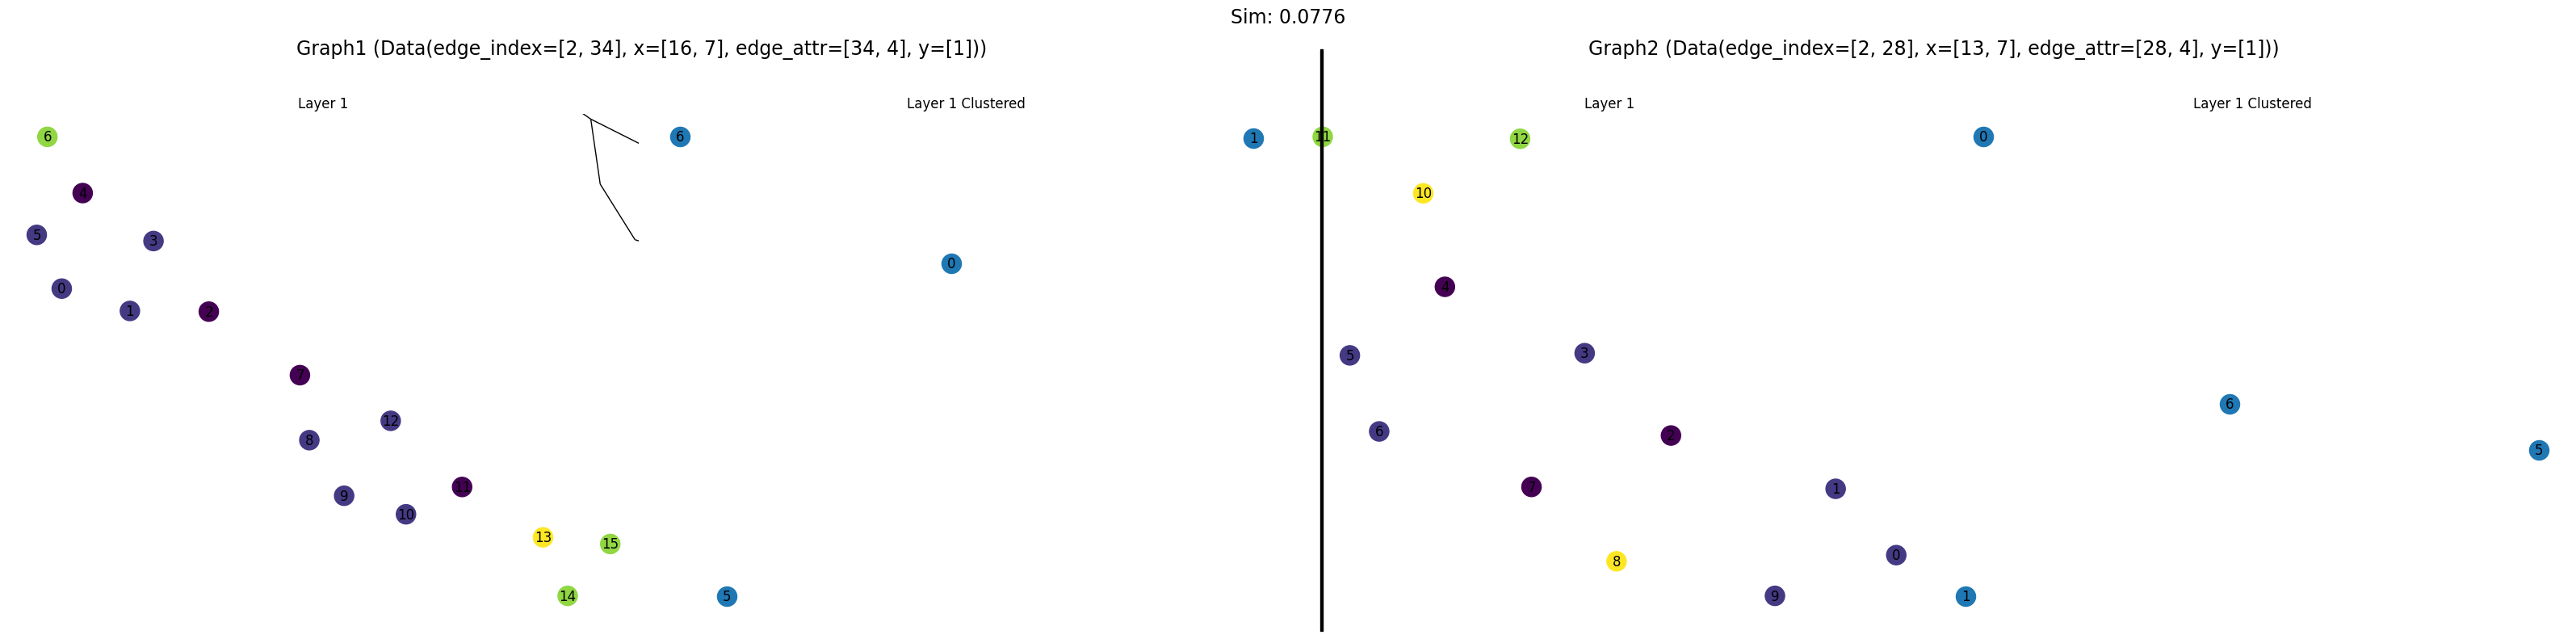

tensor(0.7311, grad_fn=<SelectBackward0>)



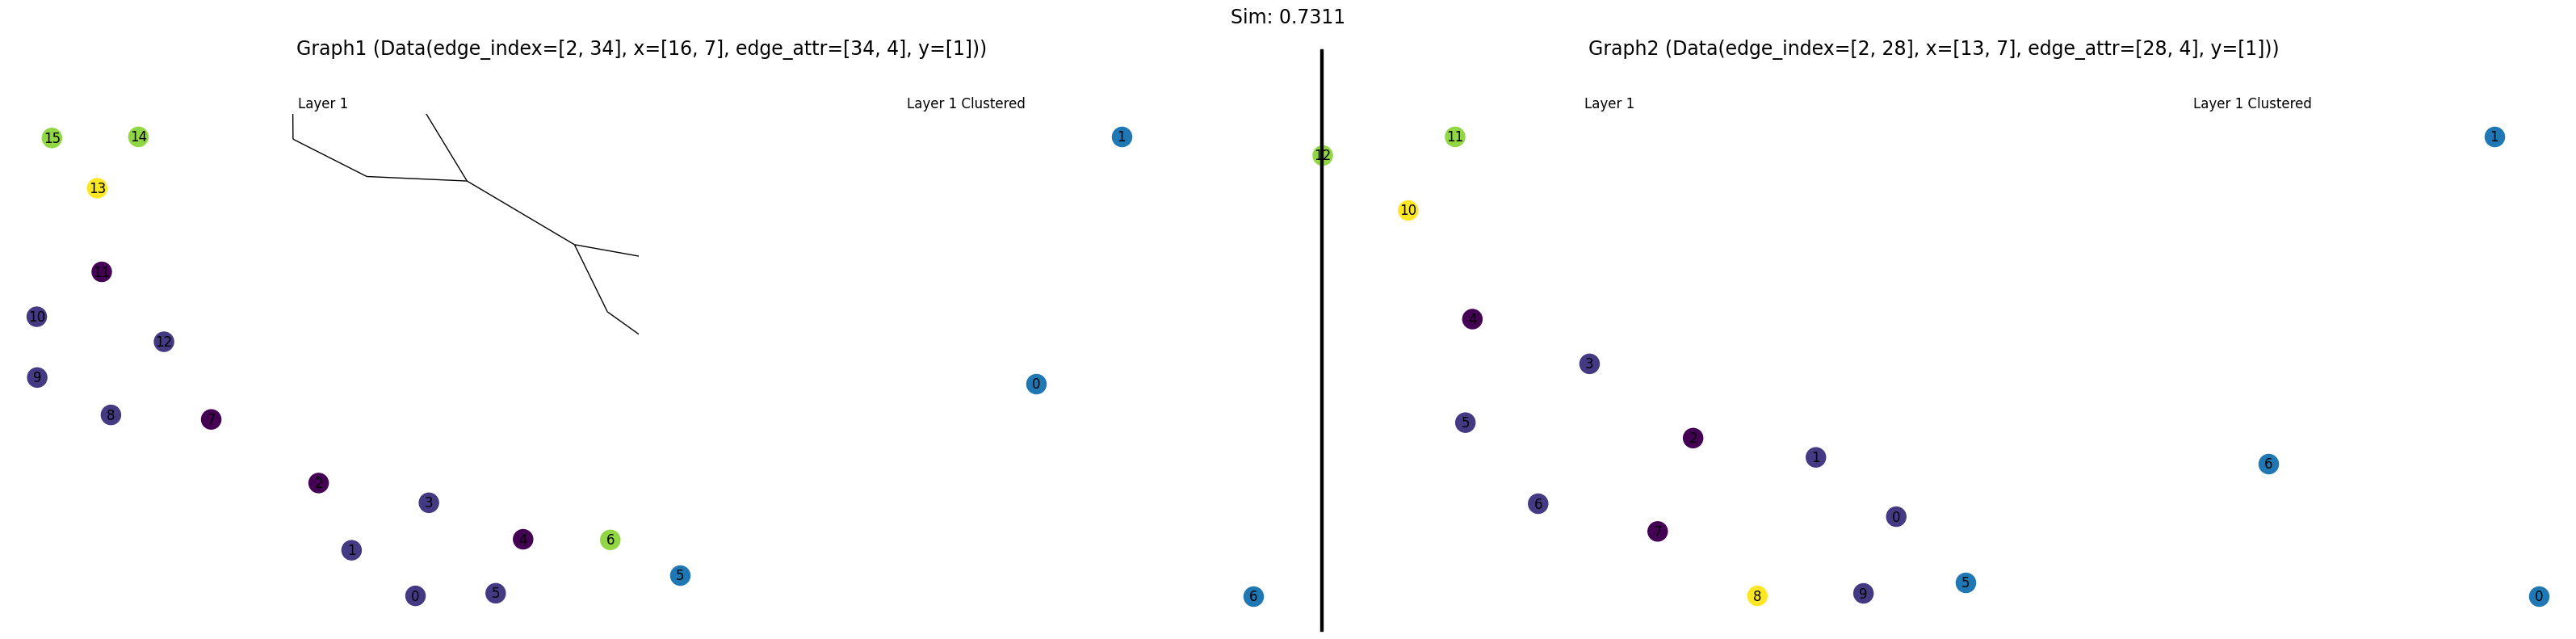

tensor(0.9791, grad_fn=<SelectBackward0>)



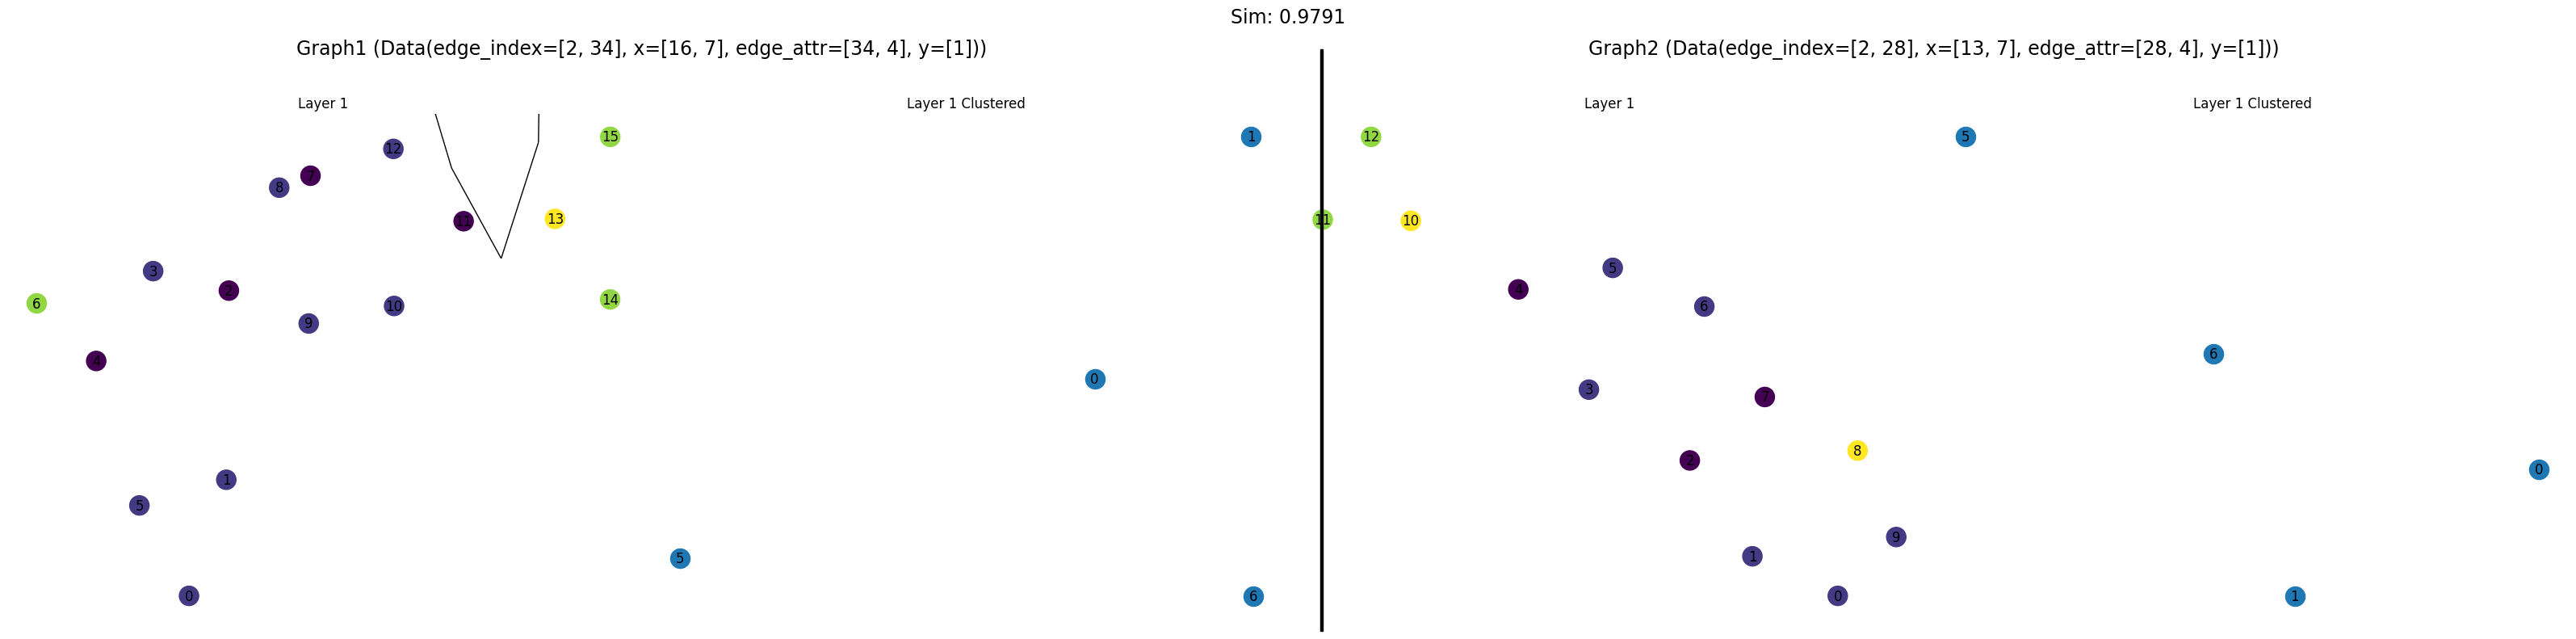

tensor(0.5252, grad_fn=<SelectBackward0>)



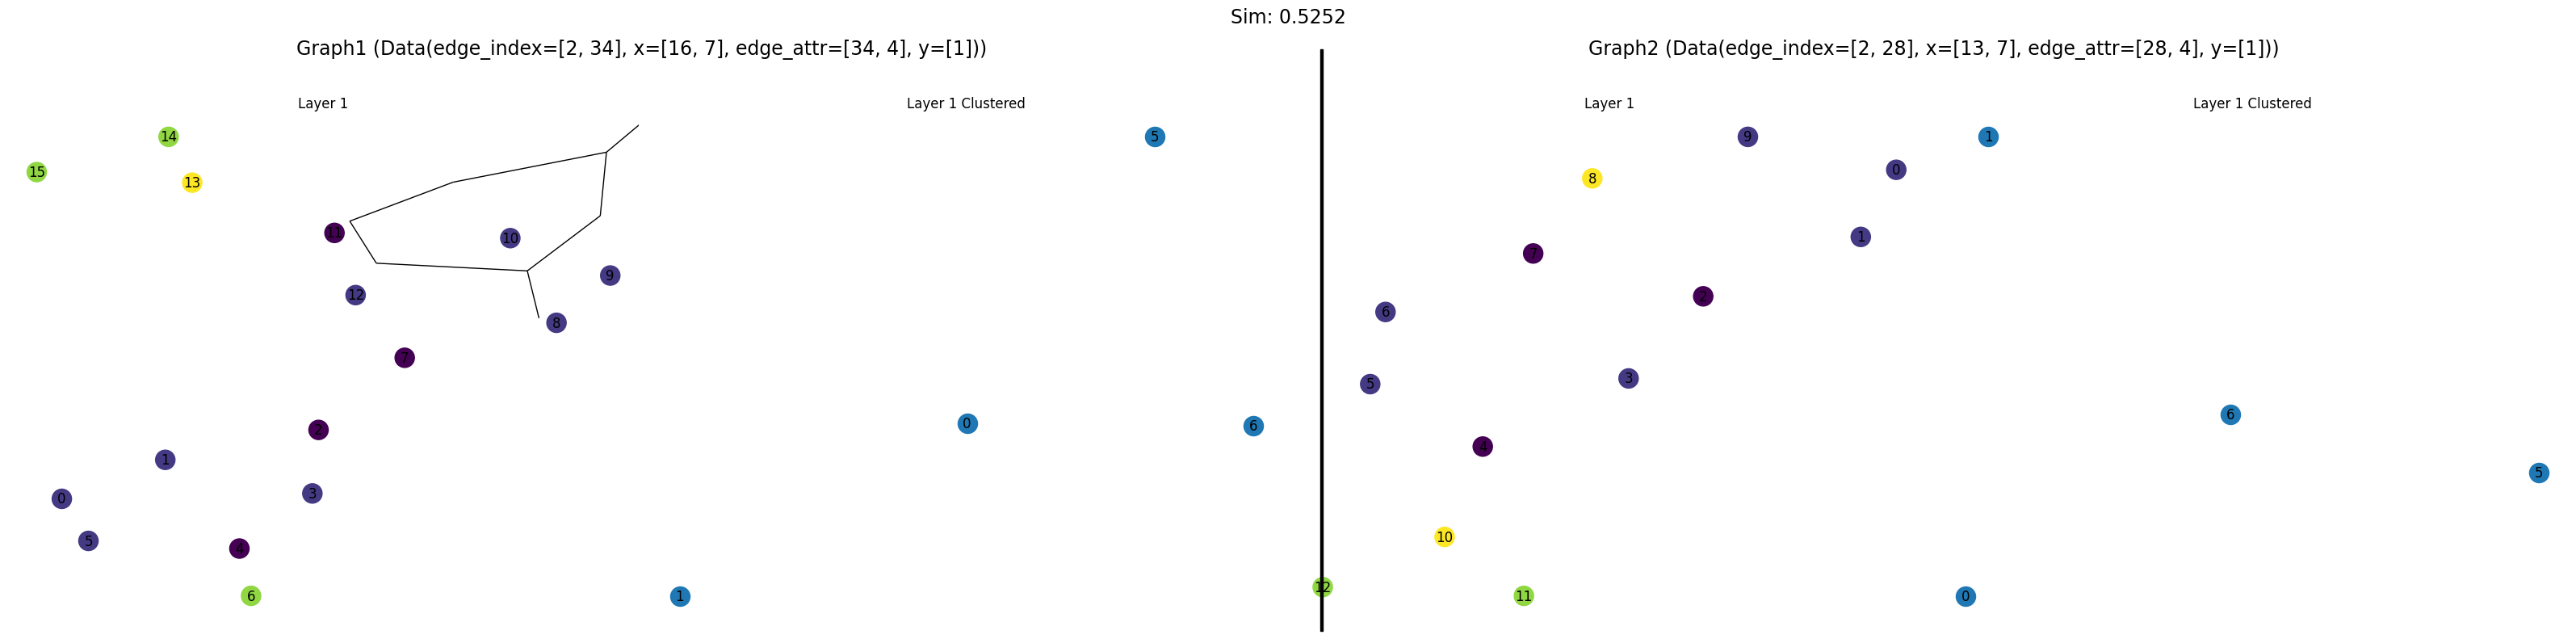

tensor(0.9898, grad_fn=<SelectBackward0>)



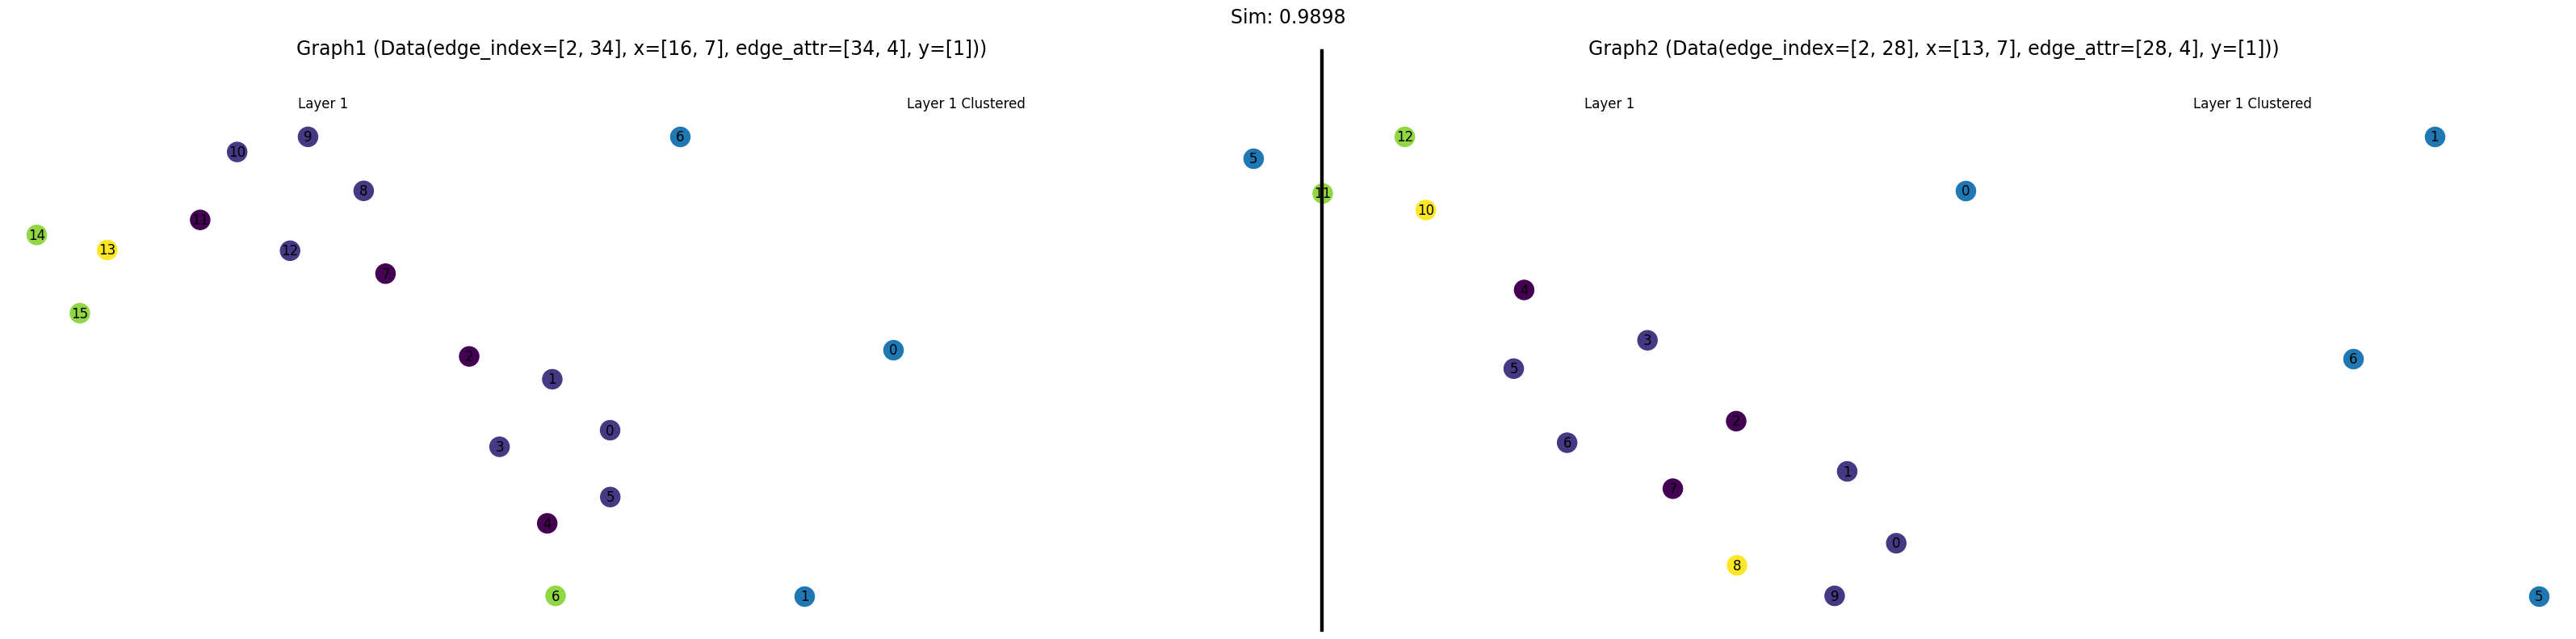

tensor(0.9187, grad_fn=<SelectBackward0>)



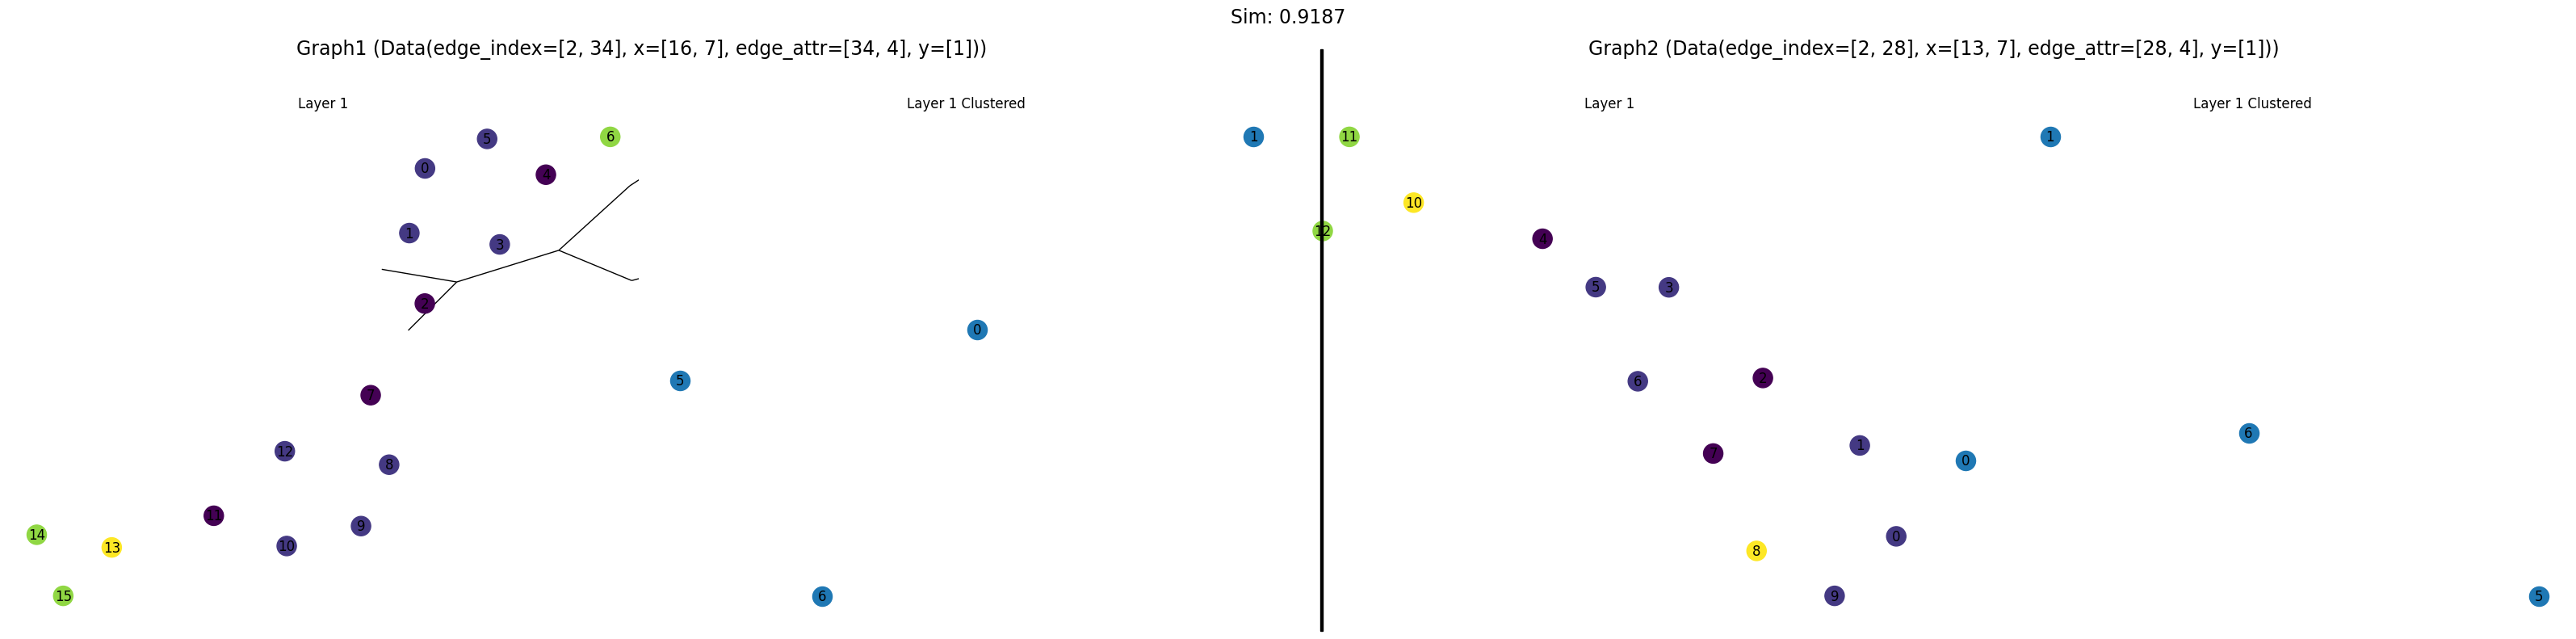

In [38]:
for i in range(len(clusters)):
    num_nodes1 = graph1.num_nodes
    num_clusters1 = clusters[i][0].max().item() + 1 

    cluster_features1 = scatter_mean(graph1.x, clusters[i][0], dim=0, dim_size=num_clusters1)

    cluster_adj_list1 = {i: set() for i in range(num_clusters1)}

    for edge_index in graph1.edge_index.t():
        source, target = edge_index
        source_cluster = clusters[i][0][source].item()
        target_cluster = clusters[i][0][target].item()
        if source_cluster != target_cluster:
            cluster_adj_list1[source_cluster].add(target_cluster)
            cluster_adj_list1[target_cluster].add(source_cluster)

    edge_sources1 = []
    edge_targets1 = []
    for source_cluster, target_clusters in cluster_adj_list1.items():
        for target_cluster in target_clusters:
            edge_sources1.append(source_cluster)
            edge_targets1.append(target_cluster)

    cluster_edge_index1 = torch.tensor([edge_sources1, edge_targets1], dtype=torch.long)

    clustered_data1 = Data(x=cluster_features1, edge_index=cluster_edge_index1)

    num_nodes2 = graph2.num_nodes
    num_clusters2 = clusters[i][1].max().item() + 1

    cluster_features2 = scatter_mean(graph2.x, clusters[i][1], dim=0, dim_size=num_clusters2)

    cluster_adj_list2 = {i: set() for i in range(num_clusters2)}

    for edge_index in graph2.edge_index.t():
        source, target = edge_index
        source_cluster = clusters[i][1][source].item()
        target_cluster = clusters[i][1][target].item()
        if source_cluster != target_cluster:
            cluster_adj_list2[source_cluster].add(target_cluster)
            cluster_adj_list2[target_cluster].add(source_cluster)

    edge_sources2 = []
    edge_targets2 = []
    for source_cluster, target_clusters in cluster_adj_list2.items():
        for target_cluster in target_clusters:
            edge_sources2.append(source_cluster)
            edge_targets2.append(target_cluster)

    cluster_edge_index2 = torch.tensor([edge_sources2, edge_targets2], dtype=torch.long)

    clustered_data2 = Data(x=cluster_features2, edge_index=cluster_edge_index2)

    feats_1, edge_index_1 = clustered_data1.x, clustered_data1.edge_index
    feats_2, edge_index_2 = clustered_data2.x, clustered_data2.edge_index
    sizes_1 = torch.tensor([len(clustered_data1.x)])
    sizes_2 = torch.tensor([len(clustered_data2.x)])
    emb1, emb2 = model(feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2)

    sim = cosine_similarity(emb1, emb2)[0]
    print(sim)

    plot_graphs([graph1.edge_index, graph2.edge_index], [clusters[0]], graph1, graph2, sim)
